#### Index 
1. Camera calibration
2. Correct for image distortion (using matrix and coef's from step 1)
3. Color and gradient threshold
4. Warp image (perspective transform)
5. Combine 1-4 (pipeline)
6. Find lanes
7. Calculate curvature and offset
8. Draw lanes
9. Define class for tracking lane properties
10. Consolidate 1-10 (process)
11. Run on videos

In [28]:
import numpy as np
import cv2
import glob

import matplotlib
#matplotlib.use("TkAgg")
#matplotlib.use("qt5agg")
import matplotlib.pyplot as plt
import matplotlib.image as mping

import os

from moviepy.editor import VideoFileClip

## (1) Camera Calibration
Do this once; all subsequent steps to be performed for each image/frame.

In [2]:
# Definte function
def calibrate_camera():
    
    #Read in and make list of images
    images = glob.glob('camera_cal/calibration*.jpg')

    x = 9
    y = 6

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prep object triples
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
    # (0,0,0),(1,0,0),...,(2,0,0),...(x-1,y-1,0)

    #%matplotlib qt

    for fname in images:

        # Read in image
        img = mping.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (x,y), corners, ret)
            ### plt.imshow(img)
            cv2.imshow('img',img)
            cv2.waitKey(500)
        else:
            print("can't find corners ", fname)      
    cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

In [3]:
# Get calibration matrix, coef's etc
ret, mtx, dist, rvecs, tvec = calibrate_camera()

can't find corners  camera_cal/calibration5.jpg
can't find corners  camera_cal/calibration4.jpg
can't find corners  camera_cal/calibration1.jpg


## (2) Undistort

In [4]:
# Undistort subsequent images using:
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

## (3) Threshold

In [5]:
### Helper functions
### Primary Gradient functions

def abs_sobel_thresh_dir(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    """
    Takes image, orientation, kernel and thresholds and returns binary image masked by gradient.
    """
    thresh_min, thresh_max = thresh[0], thresh[1]
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobelx = np.abs(sobelx)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255 * abs_sobelx/np.max(abs_sobelx))
    elif orient == 'y':
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # 3) Take the absolute value of the derivative or gradient
        abs_sobely = np.abs(sobely)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255 * abs_sobely/np.max(abs_sobely))
        
    # 5) Create a mask 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

def abs_sobel_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Takes image, ksize and thresholds and returns binary image showing abs gradient (both directions)
    """
    
    thresh_min, thresh_max = mag_thresh[0], mag_thresh[1]
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x and y 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Get Pythagorian mean of x and y gradients
    overall = np.sqrt(np.square(sobelx) + np.square(sobely))
        
    # Scale to 8-bit
    scaled_sobel = np.uint8(255 * overall/np.max(overall))
        
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Takes image, ksize and thresholds and returns binary image showing where steepness falls in range.
    Pi/2 is horizontal, 0 is vertical. NB uses modulus of gradient.
    """
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x and y 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Get angle
    angle = np.arctan2(np.abs(sobely), np.abs(sobelx))
    ########### By taking abs have only abs value of gradient, so left and right lane lines treated equally

    sbinary = np.zeros_like(angle)
    sbinary[(angle >= thresh[0]) & (angle <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sbinary
    return binary_output

In [6]:
### Helper: Combined Gradient Functions

def grad_comb(image, ksize=17, thresh_x=(60, 180), thresh_y=(60, 180),
              thresh_mag=(100, 280), thresh_dir=(0.7, 1.3)):
    """
    Takes image, kernel, x- y- and mag- ranges.
    Returns binary image showing where (x and y) or (mag and direction) are met.
    """
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh_dir(image, orient='x', sobel_kernel=ksize, thresh=thresh_x)
    grady = abs_sobel_thresh_dir(image, orient='y', sobel_kernel=ksize, thresh=thresh_y)
    mag_binary = abs_sobel_thresh(image, sobel_kernel=ksize, mag_thresh=thresh_mag)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=thresh_dir)

    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx==1) & (grady==1)) | ((mag_binary==1) & (dir_binary==1))] = 1
    
    return combined_grad

In [7]:
### Helper: Combined Color Function

# Combination - test4 has challenging shadow
def color_comb(img, thresh_s=(90,225), thresh_h=(15,40), thresh_R=(230,255)):
    """
    Takes image and three sets of ranges. Returns binary image showing where either Saturation and Hue are both 
    in range, or the Red channel is.
    """
    # Get HLS transform
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # Get Red, Hue and Saturation channels
    R = img[:,:,0]
    H=hls[:,:,0]
    S=hls[:,:,2]
    # Make binary masks
    bin_R = np.zeros_like(R)
    bin_s = np.zeros_like(S)
    bin_h = np.zeros_like(H)
    # ... applied using input ranges
    bin_R[(thresh_R[0]<R) & (R<=thresh_R[1])]=1
    bin_s[(thresh_s[0]<S) & (S<=thresh_s[1])]=1
    bin_h[(thresh_h[0]<H) & (H<=thresh_h[1])]=1

    # Combine: either both HSL channels or the Red channel
    comb = np.zeros_like(bin_R)
    comb[((bin_s==1) & (bin_h==1)) | (bin_R==1)] = 1
    
    return comb

In [8]:
### Combine combined color with combined grad
### NB Use thresh(image)[0] for image processing; 'stack' is for visualising contributions.
### This is the function to be used from this section.

def thresh(image,ksize=3, thresh_x=(18, 250), thresh_y=(0, 255),
               thresh_mag=(18, 200), thresh_dir=(0.7, 1.3),
               thresh_s=(90,255), thresh_h=(15,40), thresh_R=(240,255)):
    """
    Disjunction of grad and color combined functions.
    Returns combined binary, as well as stack.
    """
    # Apply combined functions
    grad_bin = grad_comb(image, ksize=ksize, thresh_x=thresh_x, thresh_y=thresh_y,
               thresh_mag=thresh_mag, thresh_dir=thresh_dir)
    color_bin = color_comb(image, thresh_s=thresh_s, thresh_h=thresh_h, thresh_R=thresh_R)
    # Combine - AND is very harsh but intuitively right
    comb_bin = np.zeros_like(color_bin)
    comb_bin[(grad_bin==1) | (color_bin==1)] = 1
    
    stack = np.dstack(( np.zeros_like(grad_bin), grad_bin, color_bin)) * 255
    stack = np.uint8(stack)
    
    return comb_bin, stack

## (4) Warp

In [132]:
## Helper function

# Define perspective transform function
def warp(img, inverse=False):
    """
    Set inverse=True to inverse-warp image
    """
    # Get size in (x,-y)
    img_size = (img.shape[1], img.shape[0])
    
    # Define calibration rectangle in source and destination images
    # Source (vertices of road quadrilateral, top right, counter-clock)
    src = np.float32([[673,444],[1059,691],[248,691],[605,444]])
    # Destination (eyeballing central rectangle)
    dst = np.float32(
    [[1005-25,20],
    [1005,700],
    [295,700],
    [295+25,20]])    
    
    # Compute transformation matrix
    # Create warped image using linear interpolation
    if inverse:
        M_inverse = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(img, M_inverse, img_size, flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

## (5) Combine 1-4
    Convert to gray
    Undistort
    Warp
    Apply threshold
    
This order saves computation compared to appplying threshold to entire image before subsetting.

In [10]:
# Helper
def warp_dist(img):
    gray = img # cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    undistorted = undistort(gray)
    warped_im = warp(undistorted)
    return warped_im
# Main function
def pipeline(img):
    process_1 = warp_dist(img)
    process_2 = thresh(process_1)[0]
    return process_2

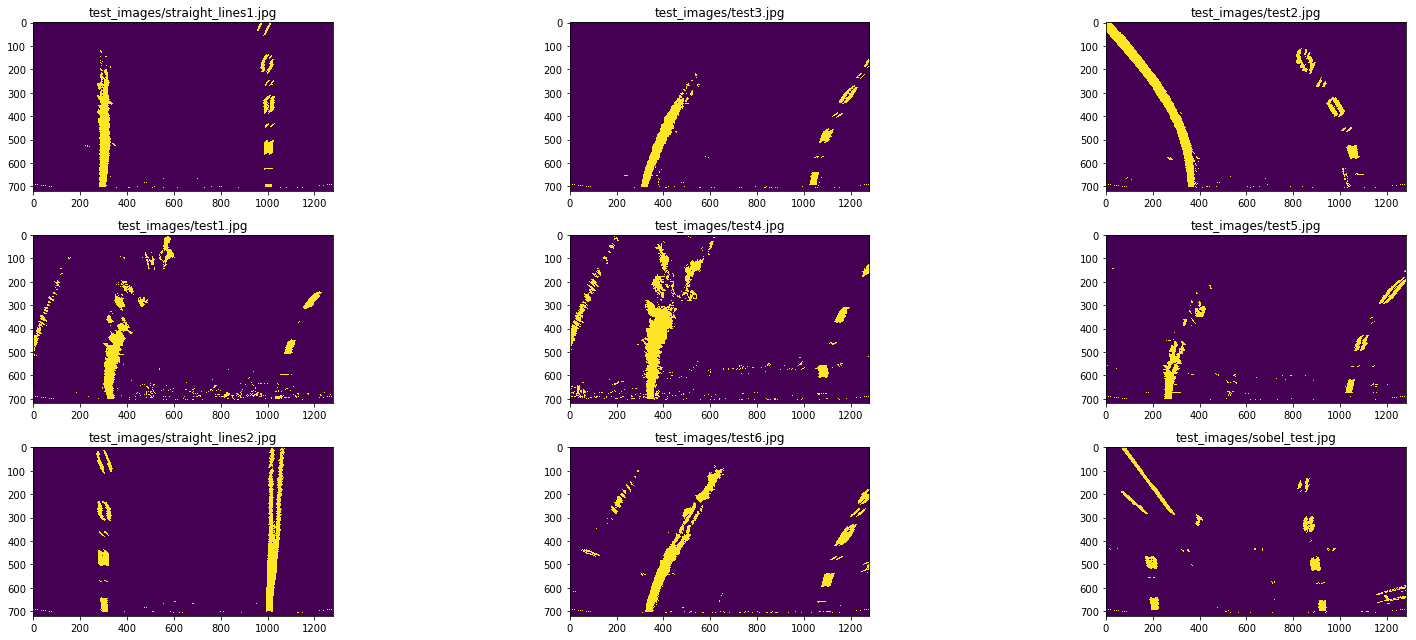

In [143]:
### Visualise pipeline so far on several images

len(os.listdir('test_images')) # => 9
% matplotlib inline
plt.figure(figsize=(24,9))
for i in range(9):
    path = 'test_images/' + os.listdir('test_images')[i]
    img = mping.imread(path)
    plt.subplot(3,3,i+1)
    plt.title(path)
    plt.imshow(pipeline(img))
plt.tight_layout()
plt.savefig('illustrations/pipeline.jpg')

## (6) Find Lanes

In [12]:
def find_lanes_prior(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, rightx

In [13]:
def viz_prior(binary_warped, left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return out_img, left_fitx, right_fitx, ploty

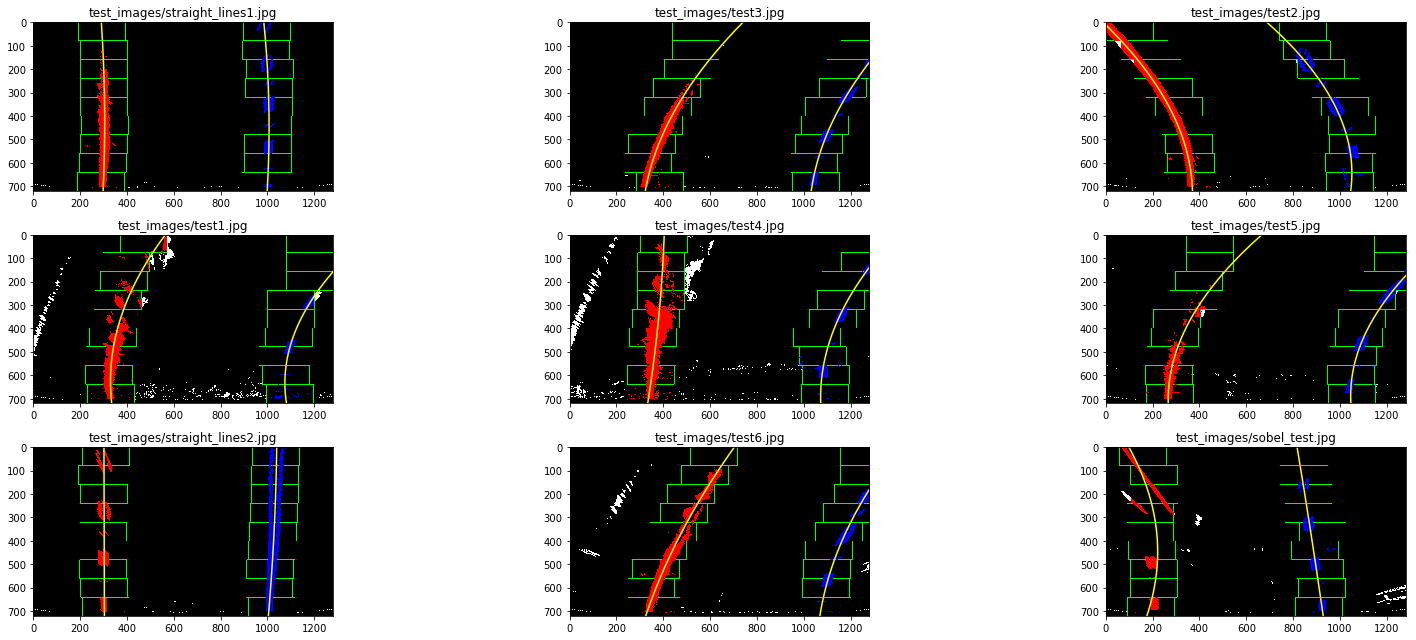

In [134]:
plt.figure(figsize=(24,9))
for i in range(9):
    path = 'test_images/' + os.listdir('test_images')[i]
    img = mping.imread(path)
    binary_warped = pipeline(img)
    plt.subplot(3,3,i+1)
    plt.title(path)
    
    left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx_old, rightx_old \
    = find_lanes_prior(binary_warped)
    
    out_img, left_fitx, right_fitx, ploty = viz_prior(binary_warped, left_fit, right_fit, out_img, \
                   nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)    

plt.tight_layout()

In [118]:
def find_lanes_posterior(binary_warped, left_fit, right_fit):
    """
    Takes new bin img, old fits; returns new fits.
    """
    #print('right_fit ', right_fit) # debugging
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print('nonzerox ',nonzerox) # debugging
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    #print('max right_lane_inds ', np.max(right_lane_inds)) # debugging
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
    right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
    
    return left_fit_new, right_fit_new, nonzerox, nonzeroy, left_lane_inds, right_lane_inds,\
left_fitx, right_fitx, leftx, rightx

In [16]:
def viz_posterior(binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fitx, right_fitx):
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    return result

In [135]:
# Test posterior lane finding
path_old = 'test_images/test1.jpg'
original_old = mping.imread(path_old)
binary_warped_old = pipeline(original_old)

left_fit_old, right_fit_old, out_img, nonzerox_old, nonzeroy_old, left_lane_inds_old, right_lane_inds_old, \
leftx_old, rightx_old = find_lanes_prior(binary_warped_old)

path_new = 'test_images/test4.jpg'
original_new = mping.imread(path_new)
binary_warped_new = pipeline(original_new)

left_fit_new, right_fit_new, nonzerox_new, nonzeroy_new, left_lane_inds_new, right_lane_inds_new,\
left_fitx_new, right_fitx_new, leftx_new, rightx_new = \
find_lanes_posterior(binary_warped_new, left_fit_old, right_fit_old)

result = viz_posterior(binary_warped_new, nonzerox_new, nonzeroy_new, left_lane_inds_new, right_lane_inds_new,\
                      left_fitx_new, right_fitx_new)

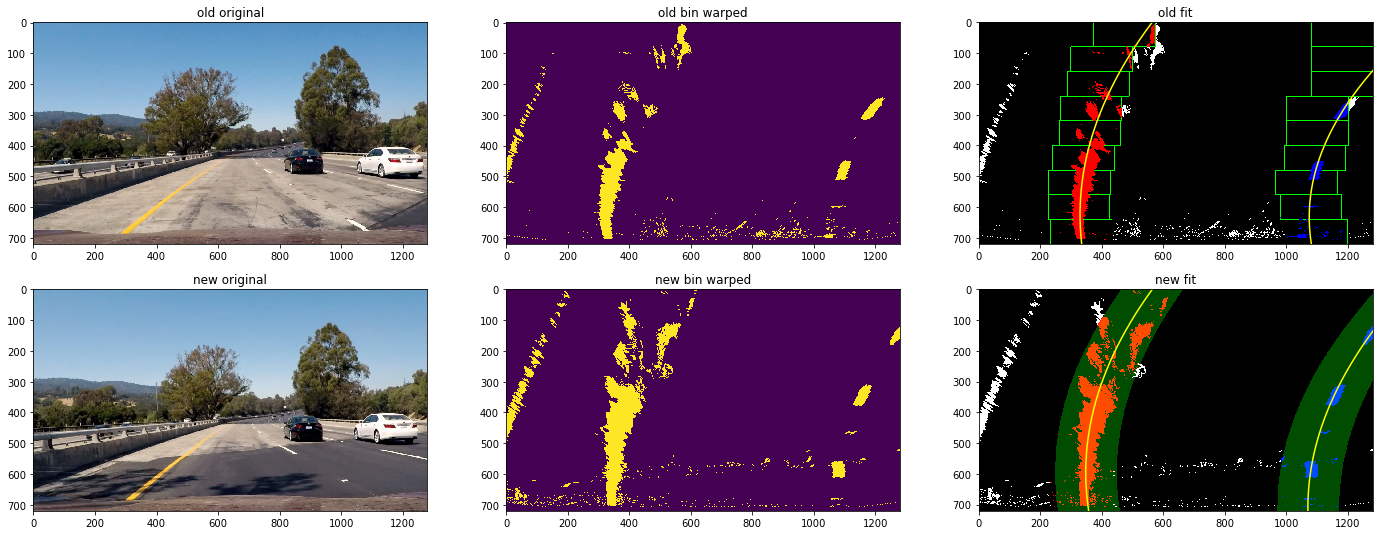

In [159]:
# Plot lane finding
plt.figure(figsize=(24,9))

plt.subplot(231)
plt.title('old original')
plt.imshow(original_old)
plt.subplot(232)
plt.title('old bin warped')
plt.imshow(binary_warped_old)

plt.subplot(233)
plt.title('old fit')
left_fit_old, right_fit_old, out_img, nonzerox_old, nonzeroy_old, left_lane_inds_old, right_lane_inds_old, \
leftx_old, rightx_old = find_lanes_prior(binary_warped_old)

out_img, left_fitx, right_fitx, ploty = viz_prior(binary_warped, left_fit_old, right_fit_old, out_img, \
               nonzerox_old, nonzeroy_old, left_lane_inds_old, right_lane_inds_old)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)  

plt.subplot(234)
plt.title('new original')
plt.imshow(original_new)
plt.subplot(235)
plt.title('new bin warped')
plt.imshow(binary_warped_new)

plt.subplot(236)
plt.title('new fit')
left_fit_new, right_fit_new, nonzerox_new, nonzeroy_new, left_lane_inds_new, right_lane_inds_new,\
left_fitx_new, right_fitx_new, leftx_new, rightx_new = \
find_lanes_posterior(binary_warped_new, left_fit_old, right_fit_old)

result = viz_posterior(binary_warped_new, nonzerox_new, nonzeroy_new, left_lane_inds_new, right_lane_inds_new,\
                      left_fitx_new, right_fitx_new)

plt.imshow(result)
plt.plot(left_fitx_new, ploty, color='yellow')
plt.plot(right_fitx_new, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#plt.show()

plt.savefig('illustrations/find_lines.jpg')

## (7) Measure Curvature and Offset

In [19]:
# Inputs are old left_fitx and y; also uses ploty, defined above outside functions.
# These are outputs 5 and 6 in find_lanes function above and needs to be called in coordination with it.

def measure_curvature(binary_warped, left_fitx, right_fitx):

    leftx = left_fitx#[::-1] # Reverse to match top-to-bottom in y
    rightx = right_fitx#[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, left_fitx, right_fitx 

In [20]:
def measure_offset(binary_warped, leftx, rightx):
    
    # Find lane centre
    lane_center = (leftx[-1] + rightx[-1]) / 2

    # Find distance from centre pixel
    central_pixel = binary_warped.shape[1]/2 #640
    offset = lane_center - central_pixel
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    offset = offset * xm_per_pix
    offset = round(offset,2)
    
    # This is car offset
    return offset

In [137]:
### Test
left_curverad, right_curverad, _, _ = measure_curvature(binary_warped_new, left_fitx_new, right_fitx_new)
offset = measure_offset(binary_warped_new, leftx_new, rightx_new)
print(left_curverad, right_curverad, offset)

269.5619476842939 256.22451456511885 0.78


## (8) Draw lanes on original image

In [22]:
## Careful to input corresponding original image (pre-distortion correction), its binary_warped, its left_fitx and y
def draw_lane(image, binary_warped, left_fitx, right_fitx):

    warped = binary_warped

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane in green onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, inverse=True)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistort(image), 1, newwarp, 0.3, 0)
    
    return result

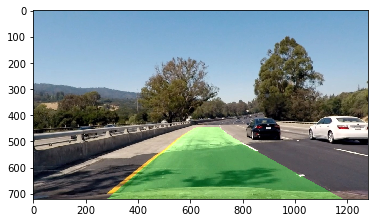

In [138]:
lane_img = draw_lane(original_new, binary_warped_new, left_fitx_new, right_fitx_new)
plt.imshow(lane_img)

In [24]:
### Calculate & annotate with curvature and offset
def annotate(img, left_fitx, right_fitx, leftx, rightx):
    
    out = np.copy(img)
    
    left_curverad, right_curverad, _, _ = measure_curvature(img, left_fitx, right_fitx)
    curv_rad = (left_curverad + right_curverad) / 2 # shd prob be harmonic mean but pixel approximations cause princ. error
    curv_rad = round(curv_rad)
    offset = measure_offset(img, leftx, rightx)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    offset_text = 'offset: ' + str(offset) + 'm left'
    curve_text = 'curvature: ' + str(curv_rad)+'m'
    out = cv2.putText(out, offset_text, (50, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    out = cv2.putText(out, curve_text, (50, 100), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    
    return out

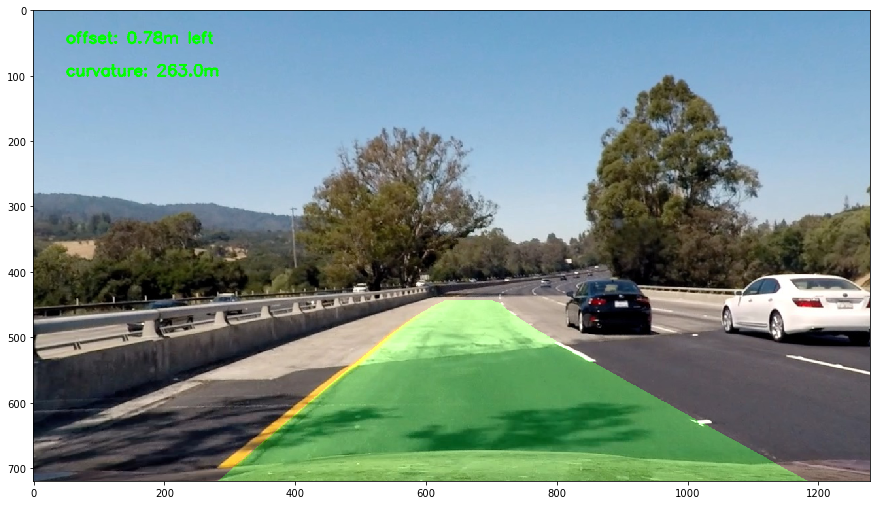

In [158]:
test = annotate(lane_img, left_fitx_new, right_fitx_new, leftx_new, rightx_new)
plt.figure(figsize=(15,10))
plt.imshow(test)
plt.savefig('illustrations/annotated.jpg')
plt.show()

## (9) Define Line class

In [55]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        ### left_fitx, right_fitx
        # list of n most recent
        self.recent_fitx = [] 
        # average
        self.best_fitx = [0,0,0]

        ### leftx, rightx  - can't merge (unfitted, different size each time)
        # current is all we need
        self.x = None
        # list of n most recent (don't use)
        self.recent_x = []
        #average x values of the fitted line over the last n iterations - don't use
        self.bestx = None             

        ### left_fit, right_fit        
        #list of polynomial coefficients for n most recent fits
        self.recent_fit = [np.array([False])]  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## (10) Consolidate all previous processes

In [117]:
def process(image):
    
    #print(right_lane.best_fit) # debugging
    
    # Binary warp
    binary_warped = pipeline(image)
    
    # Decide whether prior or posterior lane finder
    # NB I'm asuming first frame uses sliding windows, which it must.
    if left_lane.detected == False or right_lane.detected == False:
        print('no lane detected') # debugging
        left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, rightx \
        = find_lanes_prior(binary_warped) 
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_lane.recent_fit.append(left_fit)
        right_lane.recent_fit.append(right_fit)
    else:
        print('lane detected') # debugging
        left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds,\
        left_fitx, right_fitx, leftx, rightx \
        = find_lanes_posterior(binary_warped, left_fit=left_lane.recent_fit[-1], right_fit=right_lane.recent_fit[-1]) 
                                        # debugging changed
        
        # Calculate change in coefficients (later use to avoid discontinuities)
        left_lane.diffs = np.min((abs(left_lane.best_fit - left_fit), abs(left_lane.best_fit)),axis=0)
        right_lane.diffs = np.min((abs(right_lane.best_fit - right_fit), abs(right_lane.best_fit)),axis=0)
    
    # Update line classes - iff new lines are sufficiently similar to old. NB uses "axis=0" default of np.mean().
    a, b, c = 10, 50, 500
    if left_lane.diffs[0] < a and left_lane.diffs[1] < b and left_lane.diffs[2] < c:  
        left_lane.detected = True
        # left_fit
        left_lane.recent_fit.append(left_fit)
        left_lane.best_fit = np.mean(left_lane.recent_fit, axis=0)
        # left_fitx
        left_lane.recent_fitx.append(left_fitx)
        left_lane.best_fitx = np.mean(left_lane.recent_fitx, axis=0)
        # leftx - won't update if bad line
        left_lane.x = leftx
    else:
        left_lane.detected = False
    if right_lane.diffs[0] < a and right_lane.diffs[1] < b and right_lane.diffs[2] < c:  
        right_lane.detected = True
        # right_fit
        right_lane.recent_fit.append(right_fit)
        right_lane.best_fit = np.mean(right_lane.recent_fit, axis=0)
        # right_fitx
        right_lane.recent_fitx.append(right_fitx)
        right_lane.best_fitx = np.mean(right_lane.recent_fitx, axis=0)
        # rightx
        right_lane.x = rightx
    else:
        right_lane.detected = False
    
    # Keep only 8 most recent fits (at most)
    n = 4
    # left_fit
    if len(left_lane.recent_fit) > n:
        left_lane.recent_fit = left_lane.recent_fit[-n:]
    if len(right_lane.recent_fit) > n:
        right_lane.recent_fit = right_lane.recent_fit[-n:]
    # left_fitx
    if len(left_lane.recent_fitx) > n:
        left_lane.recent_fitx = left_lane.recent_fitx[-n:]
    if len(right_lane.recent_fitx) > n:
        right_lane.recent_fitx = right_lane.recent_fitx[-n:]

    # Draw lane on original
    # NB edit to use class attributes?
    out = draw_lane(image, binary_warped, left_fitx=left_lane.best_fitx, right_fitx=right_lane.best_fitx)
    # Annotate with curvature and offset
    # NB left_fitx are averages, leftx is most recent good
    out = annotate(out, left_fitx=left_lane.best_fitx, right_fitx=right_lane.best_fitx,\
                   leftx=left_lane.x, rightx=right_lane.x)

    
    return out

In [112]:
np.min((2,3))

2

no lane detected


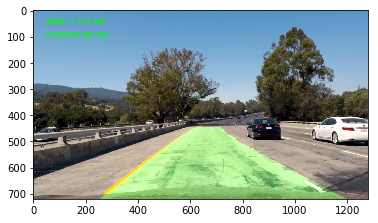

In [140]:
# Instantiate left and right lanes for updating; test process()
left_lane = Line()
right_lane = Line()
testing = process(original_old)
plt.imshow(testing)

lane detected


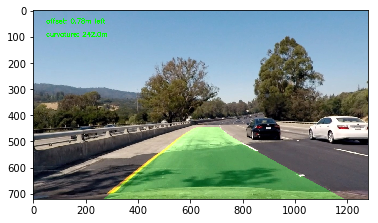

In [141]:
testing1 = process(original_new)
plt.imshow(testing1)

In [115]:
right_lane.best_fit

array([ 6.14259295e-04, -9.05097621e-01,  1.13813096e+03])

## (11) Run on video

In [142]:
### Standard
# Instantiate left and right lanes for updating
left_lane = Line()
right_lane = Line()

video_output = 'output_images/project_video_solution1.mp4'

clip = VideoFileClip('project_video.mp4')#.subclip(20,25)
## clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

clip = clip.fl_image(process)
%time clip.write_videofile(video_output, audio=False)

no lane detected
[MoviePy] >>>> Building video output_images/project_video_solution1.mp4
[MoviePy] Writing video output_images/project_video_solution1.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

lane detected




  0%|          | 2/1261 [00:00<04:28,  4.68it/s]

lane detected



  0%|          | 3/1261 [00:00<04:26,  4.71it/s]

lane detected



  0%|          | 4/1261 [00:00<04:28,  4.68it/s]

lane detected



  0%|          | 5/1261 [00:01<04:26,  4.71it/s]

lane detected



  0%|          | 6/1261 [00:01<04:23,  4.76it/s]

lane detected



  1%|          | 7/1261 [00:01<04:22,  4.78it/s]

lane detected



  1%|          | 8/1261 [00:01<04:27,  4.68it/s]

lane detected



  1%|          | 9/1261 [00:01<04:26,  4.69it/s]

lane detected



  1%|          | 10/1261 [00:02<04:29,  4.65it/s]

lane detected



  1%|          | 11/1261 [00:02<04:31,  4.61it/s]

lane detected



  1%|          | 12/1261 [00:02<04:28,  4.65it/s]

lane detected



  1%|          | 13/1261 [00:02<04:27,  4.67it/s]

lane detected



  1%|          | 14/1261 [00:02<04:28,  4.65it/s]

lane detected



  1%|          | 15/1261 [00:03<04:28,  4.63it/s]

lane detected



  1%|▏         | 16/1261 [00:03<04:31,  4.58it/s]

lane detected



  1%|▏         | 17/1261 [00:03<04:28,  4.63it/s]

lane detected



  1%|▏         | 18/1261 [00:03<04:28,  4.63it/s]

lane detected



  2%|▏         | 19/1261 [00:04<04:27,  4.64it/s]

lane detected



  2%|▏         | 20/1261 [00:04<04:23,  4.71it/s]

lane detected
lane detected



  2%|▏         | 22/1261 [00:04<04:14,  4.88it/s]

lane detected



  2%|▏         | 23/1261 [00:04<04:13,  4.89it/s]

lane detected



  2%|▏         | 24/1261 [00:05<04:15,  4.84it/s]

lane detected



  2%|▏         | 25/1261 [00:05<04:15,  4.84it/s]

lane detected



  2%|▏         | 26/1261 [00:05<04:15,  4.84it/s]

lane detected



  2%|▏         | 27/1261 [00:05<04:13,  4.87it/s]

lane detected
lane detected



  2%|▏         | 29/1261 [00:06<04:08,  4.96it/s]

lane detected



  2%|▏         | 30/1261 [00:06<04:12,  4.87it/s]

lane detected



  2%|▏         | 31/1261 [00:06<04:22,  4.68it/s]

lane detected



  3%|▎         | 32/1261 [00:06<04:26,  4.61it/s]

lane detected



  3%|▎         | 33/1261 [00:06<04:28,  4.58it/s]

lane detected



  3%|▎         | 34/1261 [00:07<04:32,  4.51it/s]

lane detected



  3%|▎         | 35/1261 [00:07<04:26,  4.59it/s]

lane detected
lane detected



  3%|▎         | 37/1261 [00:07<04:24,  4.62it/s]

lane detected



  3%|▎         | 38/1261 [00:08<04:29,  4.54it/s]

lane detected



  3%|▎         | 39/1261 [00:08<04:28,  4.55it/s]

lane detected



  3%|▎         | 40/1261 [00:08<04:30,  4.51it/s]

lane detected



  3%|▎         | 41/1261 [00:08<04:22,  4.65it/s]

lane detected
lane detected



  3%|▎         | 43/1261 [00:09<04:31,  4.49it/s]

lane detected



  3%|▎         | 44/1261 [00:09<04:27,  4.54it/s]

lane detected



  4%|▎         | 45/1261 [00:09<04:26,  4.56it/s]

lane detected



  4%|▎         | 46/1261 [00:09<04:23,  4.61it/s]

lane detected



  4%|▎         | 47/1261 [00:10<04:21,  4.64it/s]

lane detected



  4%|▍         | 48/1261 [00:10<04:18,  4.70it/s]

lane detected



  4%|▍         | 49/1261 [00:10<04:16,  4.73it/s]

lane detected



  4%|▍         | 50/1261 [00:10<04:17,  4.71it/s]

lane detected



  4%|▍         | 51/1261 [00:10<04:14,  4.76it/s]

lane detected



  4%|▍         | 52/1261 [00:11<04:15,  4.73it/s]

lane detected



  4%|▍         | 53/1261 [00:11<04:18,  4.68it/s]

lane detected



  4%|▍         | 54/1261 [00:11<04:16,  4.71it/s]

lane detected



  4%|▍         | 55/1261 [00:11<04:14,  4.74it/s]

lane detected



  4%|▍         | 56/1261 [00:11<04:13,  4.76it/s]

lane detected



  5%|▍         | 57/1261 [00:12<04:19,  4.63it/s]

lane detected



  5%|▍         | 58/1261 [00:12<04:22,  4.58it/s]

lane detected



  5%|▍         | 59/1261 [00:12<04:18,  4.64it/s]

lane detected



  5%|▍         | 60/1261 [00:12<04:24,  4.55it/s]

lane detected



  5%|▍         | 61/1261 [00:13<04:23,  4.55it/s]

lane detected



  5%|▍         | 62/1261 [00:13<04:19,  4.61it/s]

lane detected



  5%|▍         | 63/1261 [00:13<04:15,  4.69it/s]

lane detected



  5%|▌         | 64/1261 [00:13<04:16,  4.67it/s]

lane detected



  5%|▌         | 65/1261 [00:13<04:21,  4.58it/s]

lane detected



  5%|▌         | 66/1261 [00:14<04:16,  4.65it/s]

lane detected



  5%|▌         | 67/1261 [00:14<04:12,  4.72it/s]

lane detected



  5%|▌         | 68/1261 [00:14<04:30,  4.41it/s]

lane detected



  5%|▌         | 69/1261 [00:14<04:22,  4.54it/s]

lane detected



  6%|▌         | 70/1261 [00:14<04:16,  4.64it/s]

lane detected



  6%|▌         | 71/1261 [00:15<04:12,  4.71it/s]

lane detected



  6%|▌         | 72/1261 [00:15<04:09,  4.76it/s]

lane detected



  6%|▌         | 73/1261 [00:15<04:08,  4.79it/s]

lane detected



  6%|▌         | 74/1261 [00:15<04:07,  4.79it/s]

lane detected



  6%|▌         | 75/1261 [00:16<04:15,  4.64it/s]

lane detected



  6%|▌         | 76/1261 [00:16<04:10,  4.73it/s]

lane detected



  6%|▌         | 77/1261 [00:16<04:20,  4.54it/s]

lane detected



  6%|▌         | 78/1261 [00:16<04:18,  4.58it/s]

lane detected



  6%|▋         | 79/1261 [00:16<04:12,  4.68it/s]

lane detected



  6%|▋         | 80/1261 [00:17<04:08,  4.75it/s]

lane detected



  6%|▋         | 81/1261 [00:17<04:14,  4.64it/s]

lane detected



  7%|▋         | 82/1261 [00:17<04:13,  4.65it/s]

lane detected



  7%|▋         | 83/1261 [00:17<04:17,  4.57it/s]

lane detected



  7%|▋         | 84/1261 [00:17<04:21,  4.50it/s]

lane detected



  7%|▋         | 85/1261 [00:18<04:25,  4.42it/s]

lane detected



  7%|▋         | 86/1261 [00:18<04:19,  4.53it/s]

lane detected



  7%|▋         | 87/1261 [00:18<04:15,  4.60it/s]

lane detected



  7%|▋         | 88/1261 [00:18<04:11,  4.66it/s]

lane detected



  7%|▋         | 89/1261 [00:19<04:09,  4.69it/s]

lane detected



  7%|▋         | 90/1261 [00:19<04:07,  4.74it/s]

lane detected



  7%|▋         | 91/1261 [00:19<04:05,  4.76it/s]

lane detected



  7%|▋         | 92/1261 [00:19<04:04,  4.78it/s]

lane detected



  7%|▋         | 93/1261 [00:19<04:03,  4.80it/s]

lane detected



  7%|▋         | 94/1261 [00:20<04:11,  4.64it/s]

lane detected



  8%|▊         | 95/1261 [00:20<04:20,  4.48it/s]

lane detected



  8%|▊         | 96/1261 [00:20<04:30,  4.31it/s]

lane detected



  8%|▊         | 97/1261 [00:20<04:24,  4.40it/s]

lane detected



  8%|▊         | 98/1261 [00:21<04:19,  4.49it/s]

lane detected



  8%|▊         | 99/1261 [00:21<04:14,  4.57it/s]

lane detected



  8%|▊         | 100/1261 [00:21<04:12,  4.60it/s]

lane detected



  8%|▊         | 101/1261 [00:21<04:18,  4.49it/s]

lane detected



  8%|▊         | 102/1261 [00:21<04:15,  4.53it/s]

lane detected



  8%|▊         | 103/1261 [00:22<04:10,  4.61it/s]

lane detected



  8%|▊         | 104/1261 [00:22<04:07,  4.68it/s]

lane detected



  8%|▊         | 105/1261 [00:22<04:05,  4.71it/s]

lane detected



  8%|▊         | 106/1261 [00:22<04:06,  4.68it/s]

lane detected



  8%|▊         | 107/1261 [00:22<04:07,  4.66it/s]

lane detected



  9%|▊         | 108/1261 [00:23<04:06,  4.68it/s]

lane detected



  9%|▊         | 109/1261 [00:23<04:06,  4.67it/s]

lane detected



  9%|▊         | 110/1261 [00:23<04:04,  4.70it/s]

lane detected



  9%|▉         | 111/1261 [00:23<04:05,  4.69it/s]

lane detected



  9%|▉         | 112/1261 [00:24<04:02,  4.74it/s]

lane detected



  9%|▉         | 113/1261 [00:24<04:01,  4.75it/s]

lane detected



  9%|▉         | 114/1261 [00:24<03:59,  4.79it/s]

lane detected



  9%|▉         | 115/1261 [00:24<04:02,  4.74it/s]

lane detected



  9%|▉         | 116/1261 [00:24<04:04,  4.69it/s]

lane detected



  9%|▉         | 117/1261 [00:25<04:01,  4.75it/s]

lane detected



  9%|▉         | 118/1261 [00:25<03:58,  4.79it/s]

lane detected



  9%|▉         | 119/1261 [00:25<03:55,  4.84it/s]

lane detected



 10%|▉         | 120/1261 [00:25<03:53,  4.88it/s]

lane detected



 10%|▉         | 121/1261 [00:25<03:55,  4.85it/s]

lane detected



 10%|▉         | 122/1261 [00:26<04:02,  4.70it/s]

lane detected



 10%|▉         | 123/1261 [00:26<04:00,  4.74it/s]

lane detected



 10%|▉         | 124/1261 [00:26<03:59,  4.75it/s]

lane detected



 10%|▉         | 125/1261 [00:26<03:57,  4.79it/s]

lane detected



 10%|▉         | 126/1261 [00:26<03:56,  4.80it/s]

lane detected



 10%|█         | 127/1261 [00:27<03:55,  4.81it/s]

lane detected



 10%|█         | 128/1261 [00:27<03:55,  4.80it/s]

lane detected



 10%|█         | 129/1261 [00:27<03:54,  4.82it/s]

lane detected



 10%|█         | 130/1261 [00:27<03:53,  4.84it/s]

lane detected



 10%|█         | 131/1261 [00:27<03:52,  4.86it/s]

lane detected



 10%|█         | 132/1261 [00:28<03:52,  4.85it/s]

lane detected



 11%|█         | 133/1261 [00:28<03:56,  4.76it/s]

lane detected



 11%|█         | 134/1261 [00:28<03:56,  4.77it/s]

lane detected



 11%|█         | 135/1261 [00:28<03:54,  4.80it/s]

lane detected



 11%|█         | 136/1261 [00:29<03:56,  4.76it/s]

lane detected



 11%|█         | 137/1261 [00:29<03:59,  4.70it/s]

lane detected



 11%|█         | 138/1261 [00:29<04:00,  4.67it/s]

lane detected



 11%|█         | 139/1261 [00:29<03:58,  4.71it/s]

lane detected



 11%|█         | 140/1261 [00:29<04:05,  4.57it/s]

lane detected



 11%|█         | 141/1261 [00:30<04:00,  4.65it/s]

lane detected



 11%|█▏        | 142/1261 [00:30<03:58,  4.69it/s]

lane detected



 11%|█▏        | 143/1261 [00:30<04:02,  4.61it/s]

lane detected



 11%|█▏        | 144/1261 [00:30<04:01,  4.62it/s]

lane detected



 11%|█▏        | 145/1261 [00:30<03:57,  4.70it/s]

lane detected



 12%|█▏        | 146/1261 [00:31<03:59,  4.66it/s]

lane detected



 12%|█▏        | 147/1261 [00:31<03:56,  4.71it/s]

lane detected



 12%|█▏        | 148/1261 [00:31<03:55,  4.72it/s]

lane detected



 12%|█▏        | 149/1261 [00:31<03:53,  4.76it/s]

lane detected



 12%|█▏        | 150/1261 [00:32<03:52,  4.79it/s]

lane detected



 12%|█▏        | 151/1261 [00:32<03:53,  4.75it/s]

lane detected



 12%|█▏        | 152/1261 [00:32<03:59,  4.64it/s]

lane detected



 12%|█▏        | 153/1261 [00:32<03:54,  4.73it/s]

lane detected



 12%|█▏        | 154/1261 [00:32<03:51,  4.77it/s]

lane detected



 12%|█▏        | 155/1261 [00:33<03:49,  4.81it/s]

lane detected



 12%|█▏        | 156/1261 [00:33<03:48,  4.83it/s]

lane detected



 12%|█▏        | 157/1261 [00:33<03:46,  4.87it/s]

lane detected



 13%|█▎        | 158/1261 [00:33<03:53,  4.72it/s]

lane detected



 13%|█▎        | 159/1261 [00:33<03:51,  4.75it/s]

lane detected



 13%|█▎        | 160/1261 [00:34<03:50,  4.77it/s]

lane detected



 13%|█▎        | 161/1261 [00:34<03:50,  4.78it/s]

lane detected



 13%|█▎        | 162/1261 [00:34<03:48,  4.81it/s]

lane detected



 13%|█▎        | 163/1261 [00:34<03:50,  4.76it/s]

lane detected



 13%|█▎        | 164/1261 [00:34<03:49,  4.79it/s]

lane detected



 13%|█▎        | 165/1261 [00:35<03:48,  4.80it/s]

lane detected



 13%|█▎        | 166/1261 [00:35<03:46,  4.84it/s]

lane detected



 13%|█▎        | 167/1261 [00:35<03:52,  4.71it/s]

lane detected



 13%|█▎        | 168/1261 [00:35<03:49,  4.77it/s]

lane detected



 13%|█▎        | 169/1261 [00:36<03:52,  4.69it/s]

lane detected
lane detected



 14%|█▎        | 171/1261 [00:36<03:54,  4.64it/s]

lane detected



 14%|█▎        | 172/1261 [00:36<03:51,  4.71it/s]

lane detected



 14%|█▎        | 173/1261 [00:36<03:48,  4.75it/s]

lane detected



 14%|█▍        | 174/1261 [00:37<03:50,  4.71it/s]

lane detected



 14%|█▍        | 175/1261 [00:37<03:55,  4.61it/s]

lane detected



 14%|█▍        | 176/1261 [00:37<03:50,  4.70it/s]

lane detected



 14%|█▍        | 177/1261 [00:37<03:54,  4.63it/s]

lane detected



 14%|█▍        | 178/1261 [00:37<03:53,  4.63it/s]

lane detected



 14%|█▍        | 179/1261 [00:38<03:50,  4.69it/s]

lane detected



 14%|█▍        | 180/1261 [00:38<03:47,  4.75it/s]

lane detected



 14%|█▍        | 181/1261 [00:38<03:45,  4.78it/s]

lane detected



 14%|█▍        | 182/1261 [00:38<03:43,  4.82it/s]

lane detected



 15%|█▍        | 183/1261 [00:38<03:44,  4.79it/s]

lane detected



 15%|█▍        | 184/1261 [00:39<03:42,  4.83it/s]

lane detected



 15%|█▍        | 185/1261 [00:39<03:45,  4.78it/s]

lane detected



 15%|█▍        | 186/1261 [00:39<03:43,  4.82it/s]

lane detected



 15%|█▍        | 187/1261 [00:39<03:42,  4.83it/s]

lane detected



 15%|█▍        | 188/1261 [00:40<03:43,  4.80it/s]

lane detected



 15%|█▍        | 189/1261 [00:40<03:44,  4.78it/s]

lane detected



 15%|█▌        | 190/1261 [00:40<03:43,  4.80it/s]

lane detected



 15%|█▌        | 191/1261 [00:40<03:41,  4.82it/s]

lane detected



 15%|█▌        | 192/1261 [00:40<03:41,  4.83it/s]

lane detected



 15%|█▌        | 193/1261 [00:41<03:39,  4.87it/s]

lane detected



 15%|█▌        | 194/1261 [00:41<03:39,  4.86it/s]

lane detected



 15%|█▌        | 195/1261 [00:41<03:39,  4.86it/s]

lane detected



 16%|█▌        | 196/1261 [00:41<03:44,  4.74it/s]

lane detected



 16%|█▌        | 197/1261 [00:41<03:44,  4.73it/s]

lane detected



 16%|█▌        | 198/1261 [00:42<03:49,  4.63it/s]

lane detected



 16%|█▌        | 199/1261 [00:42<03:49,  4.63it/s]

lane detected



 16%|█▌        | 200/1261 [00:42<03:46,  4.68it/s]

lane detected



 16%|█▌        | 201/1261 [00:42<03:53,  4.54it/s]

lane detected



 16%|█▌        | 202/1261 [00:43<03:49,  4.61it/s]

lane detected



 16%|█▌        | 203/1261 [00:43<03:45,  4.69it/s]

lane detected



 16%|█▌        | 204/1261 [00:43<03:43,  4.73it/s]

lane detected



 16%|█▋        | 205/1261 [00:43<03:42,  4.75it/s]

lane detected



 16%|█▋        | 206/1261 [00:43<03:41,  4.76it/s]

lane detected



 16%|█▋        | 207/1261 [00:44<03:39,  4.80it/s]

lane detected



 16%|█▋        | 208/1261 [00:44<03:40,  4.78it/s]

lane detected



 17%|█▋        | 209/1261 [00:44<03:48,  4.61it/s]

lane detected



 17%|█▋        | 210/1261 [00:44<03:53,  4.50it/s]

lane detected



 17%|█▋        | 211/1261 [00:44<03:52,  4.51it/s]

lane detected



 17%|█▋        | 212/1261 [00:45<03:49,  4.57it/s]

lane detected



 17%|█▋        | 213/1261 [00:45<03:49,  4.56it/s]

lane detected



 17%|█▋        | 214/1261 [00:45<03:45,  4.65it/s]

lane detected



 17%|█▋        | 215/1261 [00:45<03:51,  4.52it/s]

lane detected



 17%|█▋        | 216/1261 [00:46<03:48,  4.58it/s]

lane detected



 17%|█▋        | 217/1261 [00:46<03:43,  4.66it/s]

lane detected



 17%|█▋        | 218/1261 [00:46<03:41,  4.71it/s]

lane detected



 17%|█▋        | 219/1261 [00:46<03:38,  4.76it/s]

lane detected



 17%|█▋        | 220/1261 [00:46<03:42,  4.69it/s]

lane detected



 18%|█▊        | 221/1261 [00:47<03:38,  4.76it/s]

lane detected



 18%|█▊        | 222/1261 [00:47<03:45,  4.61it/s]

lane detected



 18%|█▊        | 223/1261 [00:47<03:46,  4.59it/s]

lane detected



 18%|█▊        | 224/1261 [00:47<03:50,  4.50it/s]

lane detected



 18%|█▊        | 225/1261 [00:47<03:48,  4.53it/s]

lane detected



 18%|█▊        | 226/1261 [00:48<03:45,  4.59it/s]

lane detected



 18%|█▊        | 227/1261 [00:48<03:41,  4.66it/s]

lane detected



 18%|█▊        | 228/1261 [00:48<03:39,  4.71it/s]

lane detected



 18%|█▊        | 229/1261 [00:48<03:37,  4.75it/s]

lane detected



 18%|█▊        | 230/1261 [00:49<03:34,  4.81it/s]

lane detected



 18%|█▊        | 231/1261 [00:49<03:40,  4.67it/s]

lane detected



 18%|█▊        | 232/1261 [00:49<03:39,  4.69it/s]

lane detected



 18%|█▊        | 233/1261 [00:49<03:41,  4.63it/s]

lane detected



 19%|█▊        | 234/1261 [00:49<03:41,  4.64it/s]

lane detected



 19%|█▊        | 235/1261 [00:50<03:51,  4.42it/s]

lane detected



 19%|█▊        | 236/1261 [00:50<03:51,  4.43it/s]

lane detected



 19%|█▉        | 237/1261 [00:50<03:57,  4.32it/s]

lane detected



 19%|█▉        | 238/1261 [00:50<04:00,  4.25it/s]

lane detected



 19%|█▉        | 239/1261 [00:51<03:57,  4.31it/s]

lane detected



 19%|█▉        | 240/1261 [00:51<03:48,  4.46it/s]

lane detected



 19%|█▉        | 241/1261 [00:51<03:49,  4.45it/s]

lane detected



 19%|█▉        | 242/1261 [00:51<03:46,  4.50it/s]

lane detected



 19%|█▉        | 243/1261 [00:51<03:40,  4.61it/s]

lane detected



 19%|█▉        | 244/1261 [00:52<03:41,  4.59it/s]

lane detected



 19%|█▉        | 245/1261 [00:52<03:39,  4.64it/s]

lane detected



 20%|█▉        | 246/1261 [00:52<03:40,  4.61it/s]

lane detected



 20%|█▉        | 247/1261 [00:52<03:48,  4.44it/s]

lane detected



 20%|█▉        | 248/1261 [00:53<03:53,  4.34it/s]

lane detected



 20%|█▉        | 249/1261 [00:53<03:52,  4.35it/s]

lane detected



 20%|█▉        | 250/1261 [00:53<03:42,  4.54it/s]

lane detected



 20%|█▉        | 251/1261 [00:53<03:41,  4.56it/s]

lane detected



 20%|█▉        | 252/1261 [00:53<03:40,  4.59it/s]

lane detected



 20%|██        | 253/1261 [00:54<03:42,  4.53it/s]

lane detected



 20%|██        | 254/1261 [00:54<03:48,  4.41it/s]

lane detected



 20%|██        | 255/1261 [00:54<03:50,  4.36it/s]

lane detected



 20%|██        | 256/1261 [00:54<03:43,  4.50it/s]

lane detected



 20%|██        | 257/1261 [00:55<03:46,  4.43it/s]

lane detected



 20%|██        | 258/1261 [00:55<03:56,  4.23it/s]

lane detected



 21%|██        | 259/1261 [00:55<04:01,  4.14it/s]

lane detected



 21%|██        | 260/1261 [00:55<03:56,  4.23it/s]

lane detected



 21%|██        | 261/1261 [00:56<03:52,  4.30it/s]

lane detected



 21%|██        | 262/1261 [00:56<03:47,  4.39it/s]

lane detected



 21%|██        | 263/1261 [00:56<03:40,  4.52it/s]

lane detected



 21%|██        | 264/1261 [00:56<03:49,  4.34it/s]

lane detected



 21%|██        | 265/1261 [00:56<03:47,  4.37it/s]

lane detected



 21%|██        | 266/1261 [00:57<03:40,  4.52it/s]

lane detected



 21%|██        | 267/1261 [00:57<03:35,  4.62it/s]

lane detected



 21%|██▏       | 268/1261 [00:57<03:30,  4.71it/s]

lane detected



 21%|██▏       | 269/1261 [00:57<03:26,  4.79it/s]

lane detected
lane detected



 21%|██▏       | 271/1261 [00:58<03:33,  4.63it/s]

lane detected



 22%|██▏       | 272/1261 [00:58<03:39,  4.50it/s]

lane detected



 22%|██▏       | 273/1261 [00:58<03:42,  4.44it/s]

lane detected



 22%|██▏       | 274/1261 [00:58<03:46,  4.37it/s]

lane detected



 22%|██▏       | 275/1261 [00:59<03:47,  4.34it/s]

lane detected
lane detected



 22%|██▏       | 277/1261 [00:59<03:32,  4.64it/s]

lane detected
lane detected



 22%|██▏       | 279/1261 [00:59<03:24,  4.80it/s]

lane detected



 22%|██▏       | 280/1261 [01:00<03:26,  4.75it/s]

lane detected



 22%|██▏       | 281/1261 [01:00<03:29,  4.68it/s]

lane detected



 22%|██▏       | 282/1261 [01:00<03:31,  4.63it/s]

lane detected



 22%|██▏       | 283/1261 [01:00<03:32,  4.60it/s]

lane detected



 23%|██▎       | 284/1261 [01:01<03:32,  4.60it/s]

lane detected



 23%|██▎       | 285/1261 [01:01<03:31,  4.61it/s]

lane detected



 23%|██▎       | 286/1261 [01:01<03:33,  4.56it/s]

lane detected



 23%|██▎       | 287/1261 [01:01<03:30,  4.63it/s]

lane detected



 23%|██▎       | 288/1261 [01:01<03:27,  4.68it/s]

lane detected



 23%|██▎       | 289/1261 [01:02<03:33,  4.55it/s]

lane detected



 23%|██▎       | 290/1261 [01:02<03:30,  4.61it/s]

lane detected



 23%|██▎       | 291/1261 [01:02<03:26,  4.70it/s]

lane detected



 23%|██▎       | 292/1261 [01:02<03:30,  4.61it/s]

lane detected



 23%|██▎       | 293/1261 [01:02<03:33,  4.53it/s]

lane detected



 23%|██▎       | 294/1261 [01:03<03:31,  4.57it/s]

lane detected



 23%|██▎       | 295/1261 [01:03<03:31,  4.56it/s]

lane detected



 23%|██▎       | 296/1261 [01:03<03:29,  4.61it/s]

lane detected



 24%|██▎       | 297/1261 [01:03<03:24,  4.70it/s]

lane detected



 24%|██▎       | 298/1261 [01:04<03:26,  4.65it/s]

lane detected



 24%|██▎       | 299/1261 [01:04<03:24,  4.72it/s]

lane detected



 24%|██▍       | 300/1261 [01:04<03:22,  4.75it/s]

lane detected



 24%|██▍       | 301/1261 [01:04<03:21,  4.76it/s]

lane detected



 24%|██▍       | 302/1261 [01:04<03:20,  4.79it/s]

lane detected



 24%|██▍       | 303/1261 [01:05<03:18,  4.82it/s]

lane detected



 24%|██▍       | 304/1261 [01:05<03:20,  4.77it/s]

lane detected



 24%|██▍       | 305/1261 [01:05<03:22,  4.72it/s]

lane detected



 24%|██▍       | 306/1261 [01:05<03:22,  4.71it/s]

lane detected



 24%|██▍       | 307/1261 [01:05<03:26,  4.61it/s]

lane detected



 24%|██▍       | 308/1261 [01:06<03:30,  4.53it/s]

lane detected



 25%|██▍       | 309/1261 [01:06<03:32,  4.48it/s]

lane detected



 25%|██▍       | 310/1261 [01:06<03:34,  4.43it/s]

lane detected



 25%|██▍       | 311/1261 [01:06<03:28,  4.56it/s]

lane detected



 25%|██▍       | 312/1261 [01:07<03:26,  4.59it/s]

lane detected



 25%|██▍       | 313/1261 [01:07<03:22,  4.67it/s]

lane detected



 25%|██▍       | 314/1261 [01:07<03:28,  4.54it/s]

lane detected



 25%|██▍       | 315/1261 [01:07<03:27,  4.55it/s]

lane detected



 25%|██▌       | 316/1261 [01:07<03:34,  4.40it/s]

lane detected



 25%|██▌       | 317/1261 [01:08<03:29,  4.51it/s]

lane detected



 25%|██▌       | 318/1261 [01:08<03:25,  4.59it/s]

lane detected



 25%|██▌       | 319/1261 [01:08<03:30,  4.48it/s]

lane detected



 25%|██▌       | 320/1261 [01:08<03:31,  4.45it/s]

lane detected



 25%|██▌       | 321/1261 [01:09<03:32,  4.43it/s]

lane detected



 26%|██▌       | 322/1261 [01:09<03:34,  4.38it/s]

lane detected



 26%|██▌       | 323/1261 [01:09<03:36,  4.34it/s]

lane detected



 26%|██▌       | 324/1261 [01:09<03:28,  4.49it/s]

lane detected



 26%|██▌       | 325/1261 [01:09<03:30,  4.44it/s]

lane detected
lane detected



 26%|██▌       | 327/1261 [01:10<03:21,  4.64it/s]

lane detected
lane detected



 26%|██▌       | 329/1261 [01:10<03:14,  4.80it/s]

lane detected



 26%|██▌       | 330/1261 [01:10<03:13,  4.80it/s]

lane detected



 26%|██▌       | 331/1261 [01:11<03:14,  4.79it/s]

lane detected



 26%|██▋       | 332/1261 [01:11<03:13,  4.80it/s]

lane detected



 26%|██▋       | 333/1261 [01:11<03:12,  4.81it/s]

lane detected



 26%|██▋       | 334/1261 [01:11<03:11,  4.83it/s]

lane detected



 27%|██▋       | 335/1261 [01:12<03:11,  4.83it/s]

lane detected



 27%|██▋       | 336/1261 [01:12<03:10,  4.85it/s]

lane detected



 27%|██▋       | 337/1261 [01:12<03:18,  4.65it/s]

lane detected



 27%|██▋       | 338/1261 [01:12<03:20,  4.61it/s]

lane detected



 27%|██▋       | 339/1261 [01:12<03:24,  4.51it/s]

lane detected



 27%|██▋       | 340/1261 [01:13<03:21,  4.56it/s]

lane detected



 27%|██▋       | 341/1261 [01:13<03:17,  4.65it/s]

lane detected



 27%|██▋       | 342/1261 [01:13<03:19,  4.61it/s]

lane detected



 27%|██▋       | 343/1261 [01:13<03:17,  4.65it/s]

lane detected



 27%|██▋       | 344/1261 [01:13<03:16,  4.67it/s]

lane detected



 27%|██▋       | 345/1261 [01:14<03:21,  4.54it/s]

lane detected



 27%|██▋       | 346/1261 [01:14<03:21,  4.54it/s]

lane detected



 28%|██▊       | 347/1261 [01:14<03:27,  4.41it/s]

lane detected



 28%|██▊       | 348/1261 [01:14<03:22,  4.50it/s]

lane detected



 28%|██▊       | 349/1261 [01:15<03:30,  4.33it/s]

lane detected



 28%|██▊       | 350/1261 [01:15<03:25,  4.43it/s]

lane detected



 28%|██▊       | 351/1261 [01:15<03:26,  4.41it/s]

lane detected



 28%|██▊       | 352/1261 [01:15<03:21,  4.52it/s]

lane detected



 28%|██▊       | 353/1261 [01:16<03:16,  4.63it/s]

lane detected
lane detected



 28%|██▊       | 355/1261 [01:16<03:16,  4.62it/s]

lane detected



 28%|██▊       | 356/1261 [01:16<03:26,  4.39it/s]

lane detected



 28%|██▊       | 357/1261 [01:16<03:21,  4.48it/s]

lane detected



 28%|██▊       | 358/1261 [01:17<03:20,  4.51it/s]

lane detected



 28%|██▊       | 359/1261 [01:17<03:16,  4.59it/s]

lane detected
lane detected



 29%|██▊       | 361/1261 [01:17<03:14,  4.62it/s]

lane detected
lane detected



 29%|██▉       | 363/1261 [01:18<03:13,  4.64it/s]

lane detected
lane detected



 29%|██▉       | 365/1261 [01:18<03:13,  4.63it/s]

lane detected



 29%|██▉       | 366/1261 [01:18<03:10,  4.70it/s]

lane detected



 29%|██▉       | 367/1261 [01:19<03:07,  4.77it/s]

lane detected
lane detected



 29%|██▉       | 369/1261 [01:19<03:03,  4.87it/s]

lane detected



 29%|██▉       | 370/1261 [01:19<03:05,  4.80it/s]

lane detected



 29%|██▉       | 371/1261 [01:19<03:05,  4.80it/s]

lane detected
lane detected



 30%|██▉       | 373/1261 [01:20<03:00,  4.92it/s]

lane detected
lane detected


 30%|██▉       | 375/1261 [01:20<03:03,  4.82it/s]


lane detected
lane detected



 30%|██▉       | 377/1261 [01:21<03:01,  4.88it/s]

lane detected
lane detected



 30%|███       | 379/1261 [01:21<02:57,  4.97it/s]

lane detected



 30%|███       | 380/1261 [01:21<03:02,  4.81it/s]

lane detected



 30%|███       | 381/1261 [01:21<03:00,  4.86it/s]

lane detected



 30%|███       | 382/1261 [01:22<03:04,  4.76it/s]

lane detected



 30%|███       | 383/1261 [01:22<03:12,  4.57it/s]

lane detected



 30%|███       | 384/1261 [01:22<03:15,  4.48it/s]

lane detected



 31%|███       | 385/1261 [01:22<03:19,  4.38it/s]

lane detected



 31%|███       | 386/1261 [01:23<03:22,  4.31it/s]

lane detected
lane detected



 31%|███       | 388/1261 [01:23<03:10,  4.57it/s]

lane detected



 31%|███       | 389/1261 [01:23<03:07,  4.65it/s]

lane detected



 31%|███       | 390/1261 [01:23<03:07,  4.64it/s]

lane detected



 31%|███       | 391/1261 [01:24<03:05,  4.69it/s]

lane detected



 31%|███       | 392/1261 [01:24<03:04,  4.70it/s]

lane detected



 31%|███       | 393/1261 [01:24<03:09,  4.59it/s]

lane detected



 31%|███       | 394/1261 [01:24<03:05,  4.66it/s]

lane detected



 31%|███▏      | 395/1261 [01:24<03:03,  4.72it/s]

lane detected



 31%|███▏      | 396/1261 [01:25<02:59,  4.81it/s]

lane detected



 31%|███▏      | 397/1261 [01:25<03:04,  4.69it/s]

lane detected



 32%|███▏      | 398/1261 [01:25<03:06,  4.63it/s]

lane detected



 32%|███▏      | 399/1261 [01:25<03:02,  4.73it/s]

lane detected



 32%|███▏      | 400/1261 [01:26<03:04,  4.68it/s]

lane detected



 32%|███▏      | 401/1261 [01:26<03:03,  4.69it/s]

lane detected



 32%|███▏      | 402/1261 [01:26<03:02,  4.71it/s]

lane detected



 32%|███▏      | 403/1261 [01:26<03:01,  4.72it/s]

lane detected



 32%|███▏      | 404/1261 [01:26<02:58,  4.79it/s]

lane detected



 32%|███▏      | 405/1261 [01:27<03:11,  4.47it/s]

lane detected



 32%|███▏      | 406/1261 [01:27<03:18,  4.31it/s]

lane detected



 32%|███▏      | 407/1261 [01:27<03:13,  4.41it/s]

lane detected



 32%|███▏      | 408/1261 [01:27<03:12,  4.43it/s]

lane detected



 32%|███▏      | 409/1261 [01:27<03:08,  4.53it/s]

lane detected



 33%|███▎      | 410/1261 [01:28<03:09,  4.49it/s]

lane detected



 33%|███▎      | 411/1261 [01:28<03:04,  4.60it/s]

lane detected



 33%|███▎      | 412/1261 [01:28<03:04,  4.61it/s]

lane detected



 33%|███▎      | 413/1261 [01:28<03:01,  4.67it/s]

lane detected



 33%|███▎      | 414/1261 [01:29<02:59,  4.72it/s]

lane detected



 33%|███▎      | 415/1261 [01:29<02:57,  4.77it/s]

lane detected



 33%|███▎      | 416/1261 [01:29<02:56,  4.78it/s]

lane detected



 33%|███▎      | 417/1261 [01:29<02:57,  4.76it/s]

lane detected



 33%|███▎      | 418/1261 [01:29<02:55,  4.82it/s]

lane detected



 33%|███▎      | 419/1261 [01:30<02:53,  4.85it/s]

lane detected



 33%|███▎      | 420/1261 [01:30<03:03,  4.59it/s]

lane detected



 33%|███▎      | 421/1261 [01:30<03:02,  4.62it/s]

lane detected



 33%|███▎      | 422/1261 [01:30<02:59,  4.67it/s]

lane detected



 34%|███▎      | 423/1261 [01:30<02:59,  4.67it/s]

lane detected



 34%|███▎      | 424/1261 [01:31<03:00,  4.64it/s]

lane detected



 34%|███▎      | 425/1261 [01:31<03:03,  4.55it/s]

lane detected



 34%|███▍      | 426/1261 [01:31<03:07,  4.45it/s]

lane detected



 34%|███▍      | 427/1261 [01:31<03:05,  4.50it/s]

lane detected



 34%|███▍      | 428/1261 [01:32<03:01,  4.58it/s]

lane detected



 34%|███▍      | 429/1261 [01:32<02:56,  4.72it/s]

lane detected



 34%|███▍      | 430/1261 [01:32<02:54,  4.76it/s]

lane detected



 34%|███▍      | 431/1261 [01:32<02:53,  4.78it/s]

lane detected



 34%|███▍      | 432/1261 [01:32<02:54,  4.75it/s]

lane detected



 34%|███▍      | 433/1261 [01:33<02:53,  4.78it/s]

lane detected



 34%|███▍      | 434/1261 [01:33<02:53,  4.78it/s]

lane detected



 34%|███▍      | 435/1261 [01:33<02:55,  4.70it/s]

lane detected



 35%|███▍      | 436/1261 [01:33<02:55,  4.69it/s]

lane detected



 35%|███▍      | 437/1261 [01:33<03:02,  4.52it/s]

lane detected



 35%|███▍      | 438/1261 [01:34<02:59,  4.58it/s]

lane detected



 35%|███▍      | 439/1261 [01:34<02:57,  4.63it/s]

lane detected



 35%|███▍      | 440/1261 [01:34<02:56,  4.66it/s]

lane detected



 35%|███▍      | 441/1261 [01:34<02:55,  4.68it/s]

lane detected



 35%|███▌      | 442/1261 [01:35<02:56,  4.65it/s]

lane detected



 35%|███▌      | 443/1261 [01:35<02:52,  4.75it/s]

lane detected



 35%|███▌      | 444/1261 [01:35<02:56,  4.62it/s]

lane detected
lane detected



 35%|███▌      | 446/1261 [01:35<02:52,  4.71it/s]

lane detected
lane detected



 36%|███▌      | 448/1261 [01:36<02:48,  4.82it/s]

lane detected



 36%|███▌      | 449/1261 [01:36<02:49,  4.79it/s]

lane detected



 36%|███▌      | 450/1261 [01:36<02:47,  4.83it/s]

lane detected



 36%|███▌      | 451/1261 [01:36<02:46,  4.87it/s]

lane detected



 36%|███▌      | 452/1261 [01:37<02:45,  4.87it/s]

lane detected



 36%|███▌      | 453/1261 [01:37<02:45,  4.88it/s]

lane detected



 36%|███▌      | 454/1261 [01:37<02:44,  4.90it/s]

lane detected



 36%|███▌      | 455/1261 [01:37<02:53,  4.63it/s]

lane detected



 36%|███▌      | 456/1261 [01:37<02:50,  4.71it/s]

lane detected



 36%|███▌      | 457/1261 [01:38<02:50,  4.73it/s]

lane detected



 36%|███▋      | 458/1261 [01:38<02:55,  4.57it/s]

lane detected



 36%|███▋      | 459/1261 [01:38<02:57,  4.51it/s]

lane detected



 36%|███▋      | 460/1261 [01:38<02:56,  4.55it/s]

lane detected



 37%|███▋      | 461/1261 [01:39<03:04,  4.33it/s]

lane detected



 37%|███▋      | 462/1261 [01:39<02:59,  4.45it/s]

lane detected



 37%|███▋      | 463/1261 [01:39<02:54,  4.57it/s]

lane detected



 37%|███▋      | 464/1261 [01:39<02:52,  4.63it/s]

lane detected



 37%|███▋      | 465/1261 [01:39<02:49,  4.69it/s]

lane detected



 37%|███▋      | 466/1261 [01:40<02:46,  4.77it/s]

lane detected



 37%|███▋      | 467/1261 [01:40<02:46,  4.76it/s]

lane detected



 37%|███▋      | 468/1261 [01:40<02:47,  4.73it/s]

lane detected



 37%|███▋      | 469/1261 [01:40<02:45,  4.77it/s]

lane detected



 37%|███▋      | 470/1261 [01:40<02:44,  4.80it/s]

lane detected



 37%|███▋      | 471/1261 [01:41<02:47,  4.72it/s]

lane detected



 37%|███▋      | 472/1261 [01:41<02:45,  4.78it/s]

lane detected



 38%|███▊      | 473/1261 [01:41<02:47,  4.70it/s]

lane detected



 38%|███▊      | 474/1261 [01:41<02:48,  4.67it/s]

lane detected



 38%|███▊      | 475/1261 [01:42<02:46,  4.73it/s]

lane detected



 38%|███▊      | 476/1261 [01:42<02:43,  4.81it/s]

lane detected



 38%|███▊      | 477/1261 [01:42<02:42,  4.81it/s]

lane detected
lane detected


 38%|███▊      | 479/1261 [01:42<02:45,  4.73it/s]


lane detected



 38%|███▊      | 480/1261 [01:43<02:43,  4.77it/s]

lane detected



 38%|███▊      | 481/1261 [01:43<02:43,  4.77it/s]

lane detected



 38%|███▊      | 482/1261 [01:43<02:42,  4.80it/s]

lane detected



 38%|███▊      | 483/1261 [01:43<02:43,  4.75it/s]

lane detected



 38%|███▊      | 484/1261 [01:43<02:45,  4.70it/s]

lane detected



 38%|███▊      | 485/1261 [01:44<02:50,  4.55it/s]

lane detected



 39%|███▊      | 486/1261 [01:44<02:49,  4.57it/s]

lane detected



 39%|███▊      | 487/1261 [01:44<02:53,  4.47it/s]

lane detected



 39%|███▊      | 488/1261 [01:44<02:52,  4.49it/s]

lane detected



 39%|███▉      | 489/1261 [01:45<02:55,  4.41it/s]

lane detected



 39%|███▉      | 490/1261 [01:45<02:51,  4.50it/s]

lane detected



 39%|███▉      | 491/1261 [01:45<02:50,  4.52it/s]

lane detected
lane detected



 39%|███▉      | 493/1261 [01:45<02:41,  4.76it/s]

lane detected
lane detected



 39%|███▉      | 495/1261 [01:46<02:38,  4.84it/s]

lane detected



 39%|███▉      | 496/1261 [01:46<02:37,  4.87it/s]

lane detected



 39%|███▉      | 497/1261 [01:46<02:40,  4.77it/s]

lane detected



 39%|███▉      | 498/1261 [01:46<02:40,  4.76it/s]

lane detected



 40%|███▉      | 499/1261 [01:47<02:46,  4.58it/s]

lane detected



 40%|███▉      | 500/1261 [01:47<02:42,  4.68it/s]

lane detected



 40%|███▉      | 501/1261 [01:47<02:44,  4.63it/s]

lane detected



 40%|███▉      | 502/1261 [01:47<02:42,  4.67it/s]

lane detected



 40%|███▉      | 503/1261 [01:48<02:43,  4.64it/s]

lane detected



 40%|███▉      | 504/1261 [01:48<02:43,  4.63it/s]

lane detected



 40%|████      | 505/1261 [01:48<02:47,  4.52it/s]

lane detected
lane detected



 40%|████      | 507/1261 [01:48<02:43,  4.60it/s]

lane detected
lane detected



 40%|████      | 509/1261 [01:49<02:37,  4.78it/s]

lane detected
lane detected



 41%|████      | 511/1261 [01:49<02:37,  4.77it/s]

lane detected



 41%|████      | 512/1261 [01:49<02:40,  4.68it/s]

lane detected



 41%|████      | 513/1261 [01:50<02:38,  4.71it/s]

lane detected
lane detected



 41%|████      | 515/1261 [01:50<02:34,  4.82it/s]

lane detected



 41%|████      | 516/1261 [01:50<02:34,  4.83it/s]

lane detected



 41%|████      | 517/1261 [01:51<02:33,  4.84it/s]

lane detected
lane detected


 41%|████      | 519/1261 [01:51<02:32,  4.87it/s]


lane detected
lane detected



 41%|████▏     | 521/1261 [01:51<02:30,  4.91it/s]

lane detected



 41%|████▏     | 522/1261 [01:52<02:33,  4.80it/s]

lane detected



 41%|████▏     | 523/1261 [01:52<02:36,  4.70it/s]

lane detected



 42%|████▏     | 524/1261 [01:52<02:36,  4.71it/s]

lane detected



 42%|████▏     | 525/1261 [01:52<02:35,  4.75it/s]

lane detected



 42%|████▏     | 526/1261 [01:52<02:45,  4.45it/s]

lane detected



 42%|████▏     | 527/1261 [01:53<02:59,  4.10it/s]

lane detected



 42%|████▏     | 528/1261 [01:53<03:07,  3.92it/s]

lane detected



 42%|████▏     | 529/1261 [01:53<03:02,  4.02it/s]

lane detected



 42%|████▏     | 530/1261 [01:53<03:02,  4.00it/s]

lane detected



 42%|████▏     | 531/1261 [01:54<02:57,  4.11it/s]

lane detected



 42%|████▏     | 532/1261 [01:54<02:49,  4.30it/s]

lane detected



 42%|████▏     | 533/1261 [01:54<02:42,  4.49it/s]

lane detected



 42%|████▏     | 534/1261 [01:54<02:39,  4.57it/s]

lane detected



 42%|████▏     | 535/1261 [01:55<02:35,  4.67it/s]

lane detected



 43%|████▎     | 536/1261 [01:55<02:35,  4.68it/s]

lane detected



 43%|████▎     | 537/1261 [01:55<02:38,  4.56it/s]

lane detected



 43%|████▎     | 538/1261 [01:55<02:36,  4.62it/s]

lane detected



 43%|████▎     | 539/1261 [01:55<02:39,  4.52it/s]

lane detected



 43%|████▎     | 540/1261 [01:56<02:36,  4.62it/s]

lane detected



 43%|████▎     | 541/1261 [01:56<02:32,  4.71it/s]

lane detected



 43%|████▎     | 542/1261 [01:56<02:31,  4.75it/s]

lane detected
lane detected



 43%|████▎     | 544/1261 [01:56<02:26,  4.88it/s]

lane detected



 43%|████▎     | 545/1261 [01:57<02:26,  4.90it/s]

lane detected



 43%|████▎     | 546/1261 [01:57<02:25,  4.92it/s]

lane detected
lane detected



 43%|████▎     | 548/1261 [01:57<02:26,  4.86it/s]

lane detected



 44%|████▎     | 549/1261 [01:57<02:27,  4.83it/s]

lane detected



 44%|████▎     | 550/1261 [01:58<02:26,  4.84it/s]

lane detected



 44%|████▎     | 551/1261 [01:58<02:26,  4.84it/s]

lane detected
lane detected



 44%|████▍     | 553/1261 [01:58<02:25,  4.88it/s]

lane detected
lane detected



 44%|████▍     | 555/1261 [01:59<02:24,  4.89it/s]

lane detected
lane detected



 44%|████▍     | 557/1261 [01:59<02:23,  4.92it/s]

lane detected
lane detected



 44%|████▍     | 559/1261 [02:00<02:27,  4.76it/s]

lane detected



 44%|████▍     | 560/1261 [02:00<02:37,  4.45it/s]

lane detected



 44%|████▍     | 561/1261 [02:00<02:35,  4.50it/s]

lane detected



 45%|████▍     | 562/1261 [02:00<02:40,  4.35it/s]

lane detected



 45%|████▍     | 563/1261 [02:00<02:37,  4.42it/s]

lane detected



 45%|████▍     | 564/1261 [02:01<02:37,  4.43it/s]

lane detected



 45%|████▍     | 565/1261 [02:01<02:45,  4.20it/s]

lane detected



 45%|████▍     | 566/1261 [02:01<02:45,  4.19it/s]

lane detected



 45%|████▍     | 567/1261 [02:01<02:52,  4.02it/s]

lane detected



 45%|████▌     | 568/1261 [02:02<03:01,  3.83it/s]

lane detected



 45%|████▌     | 569/1261 [02:02<03:01,  3.82it/s]

lane detected



 45%|████▌     | 570/1261 [02:02<03:01,  3.82it/s]

lane detected



 45%|████▌     | 571/1261 [02:03<02:55,  3.93it/s]

lane detected



 45%|████▌     | 572/1261 [02:03<02:52,  4.00it/s]

lane detected



 45%|████▌     | 573/1261 [02:03<02:48,  4.08it/s]

lane detected



 46%|████▌     | 574/1261 [02:03<02:50,  4.04it/s]

lane detected



 46%|████▌     | 575/1261 [02:03<02:51,  4.00it/s]

lane detected



 46%|████▌     | 576/1261 [02:04<02:56,  3.87it/s]

lane detected



 46%|████▌     | 577/1261 [02:04<03:05,  3.68it/s]

lane detected



 46%|████▌     | 578/1261 [02:04<03:18,  3.44it/s]

lane detected



 46%|████▌     | 579/1261 [02:05<03:20,  3.40it/s]

lane detected



 46%|████▌     | 580/1261 [02:05<03:25,  3.32it/s]

lane detected



 46%|████▌     | 581/1261 [02:05<03:25,  3.31it/s]

lane detected



 46%|████▌     | 582/1261 [02:06<03:19,  3.41it/s]

lane detected



 46%|████▌     | 583/1261 [02:06<03:10,  3.56it/s]

lane detected



 46%|████▋     | 584/1261 [02:06<03:17,  3.43it/s]

lane detected



 46%|████▋     | 585/1261 [02:06<03:10,  3.55it/s]

lane detected



 46%|████▋     | 586/1261 [02:07<03:05,  3.64it/s]

lane detected



 47%|████▋     | 587/1261 [02:07<03:11,  3.53it/s]

lane detected



 47%|████▋     | 588/1261 [02:07<03:09,  3.55it/s]

lane detected



 47%|████▋     | 589/1261 [02:08<03:02,  3.68it/s]

lane detected



 47%|████▋     | 590/1261 [02:08<02:55,  3.83it/s]

lane detected



 47%|████▋     | 591/1261 [02:08<03:04,  3.64it/s]

lane detected



 47%|████▋     | 592/1261 [02:08<02:59,  3.73it/s]

lane detected



 47%|████▋     | 593/1261 [02:09<02:51,  3.89it/s]

lane detected



 47%|████▋     | 594/1261 [02:09<02:57,  3.76it/s]

lane detected



 47%|████▋     | 595/1261 [02:09<03:09,  3.51it/s]

lane detected



 47%|████▋     | 596/1261 [02:09<03:06,  3.57it/s]

lane detected



 47%|████▋     | 597/1261 [02:10<03:00,  3.69it/s]

lane detected



 47%|████▋     | 598/1261 [02:10<02:48,  3.94it/s]

lane detected



 48%|████▊     | 599/1261 [02:10<02:38,  4.17it/s]

lane detected



 48%|████▊     | 600/1261 [02:10<02:37,  4.20it/s]

lane detected



 48%|████▊     | 601/1261 [02:11<02:36,  4.22it/s]

lane detected



 48%|████▊     | 602/1261 [02:11<02:35,  4.24it/s]

lane detected



 48%|████▊     | 603/1261 [02:11<02:34,  4.26it/s]

lane detected



 48%|████▊     | 604/1261 [02:11<02:36,  4.20it/s]

lane detected



 48%|████▊     | 605/1261 [02:12<02:31,  4.34it/s]

lane detected



 48%|████▊     | 606/1261 [02:12<02:25,  4.49it/s]

lane detected



 48%|████▊     | 607/1261 [02:12<02:21,  4.62it/s]

lane detected



 48%|████▊     | 608/1261 [02:12<02:25,  4.49it/s]

lane detected



 48%|████▊     | 609/1261 [02:12<02:29,  4.36it/s]

lane detected



 48%|████▊     | 610/1261 [02:13<02:29,  4.37it/s]

lane detected



 48%|████▊     | 611/1261 [02:13<02:29,  4.35it/s]

lane detected



 49%|████▊     | 612/1261 [02:13<02:34,  4.20it/s]

lane detected



 49%|████▊     | 613/1261 [02:13<02:45,  3.92it/s]

lane detected



 49%|████▊     | 614/1261 [02:14<02:41,  4.01it/s]

lane detected



 49%|████▉     | 615/1261 [02:14<02:46,  3.88it/s]

lane detected



 49%|████▉     | 616/1261 [02:14<02:41,  3.99it/s]

lane detected



 49%|████▉     | 617/1261 [02:14<02:35,  4.14it/s]

lane detected



 49%|████▉     | 618/1261 [02:15<02:28,  4.34it/s]

lane detected



 49%|████▉     | 619/1261 [02:15<02:23,  4.48it/s]

lane detected



 49%|████▉     | 620/1261 [02:15<02:19,  4.59it/s]

lane detected



 49%|████▉     | 621/1261 [02:15<02:15,  4.71it/s]

lane detected
lane detected


 49%|████▉     | 622/1261 [02:15<02:13,  4.78it/s]


 49%|████▉     | 623/1261 [02:16<02:11,  4.84it/s]

lane detected



 49%|████▉     | 624/1261 [02:16<02:11,  4.85it/s]

lane detected



 50%|████▉     | 625/1261 [02:16<02:09,  4.90it/s]

lane detected
lane detected



 50%|████▉     | 627/1261 [02:16<02:07,  4.97it/s]

lane detected
lane detected



 50%|████▉     | 629/1261 [02:17<02:07,  4.96it/s]

lane detected
lane detected



 50%|█████     | 631/1261 [02:17<02:06,  4.99it/s]

lane detected



 50%|█████     | 632/1261 [02:17<02:06,  4.98it/s]

lane detected



 50%|█████     | 633/1261 [02:18<02:06,  4.97it/s]

lane detected
lane detected



 50%|█████     | 635/1261 [02:18<02:04,  5.04it/s]

lane detected



 50%|█████     | 636/1261 [02:18<02:05,  5.00it/s]

lane detected



 51%|█████     | 637/1261 [02:18<02:05,  4.96it/s]

lane detected
lane detected



 51%|█████     | 639/1261 [02:19<02:04,  4.99it/s]

lane detected
lane detected



 51%|█████     | 641/1261 [02:19<02:04,  4.98it/s]

lane detected
lane detected



 51%|█████     | 643/1261 [02:20<02:07,  4.84it/s]

lane detected



 51%|█████     | 644/1261 [02:20<02:09,  4.77it/s]

lane detected



 51%|█████     | 645/1261 [02:20<02:11,  4.67it/s]

lane detected



 51%|█████     | 646/1261 [02:20<02:11,  4.69it/s]

lane detected



 51%|█████▏    | 647/1261 [02:20<02:11,  4.68it/s]

lane detected



 51%|█████▏    | 648/1261 [02:21<02:08,  4.76it/s]

lane detected



 51%|█████▏    | 649/1261 [02:21<02:07,  4.80it/s]

lane detected
lane detected



 52%|█████▏    | 651/1261 [02:21<02:04,  4.89it/s]

lane detected
lane detected



 52%|█████▏    | 653/1261 [02:22<02:02,  4.96it/s]

lane detected
lane detected



 52%|█████▏    | 655/1261 [02:22<02:00,  5.01it/s]

lane detected
lane detected



 52%|█████▏    | 657/1261 [02:22<02:00,  5.02it/s]

lane detected
lane detected



 52%|█████▏    | 659/1261 [02:23<01:59,  5.04it/s]

lane detected
lane detected



 52%|█████▏    | 661/1261 [02:23<01:58,  5.06it/s]

lane detected



 52%|█████▏    | 662/1261 [02:23<02:00,  4.97it/s]

lane detected



 53%|█████▎    | 663/1261 [02:24<02:03,  4.83it/s]

lane detected



 53%|█████▎    | 664/1261 [02:24<02:04,  4.81it/s]

lane detected



 53%|█████▎    | 665/1261 [02:24<02:03,  4.81it/s]

lane detected



 53%|█████▎    | 666/1261 [02:24<02:03,  4.83it/s]

lane detected



 53%|█████▎    | 667/1261 [02:25<02:03,  4.82it/s]

lane detected



 53%|█████▎    | 668/1261 [02:25<02:05,  4.72it/s]

lane detected



 53%|█████▎    | 669/1261 [02:25<02:19,  4.26it/s]

lane detected



 53%|█████▎    | 670/1261 [02:25<02:26,  4.05it/s]

lane detected



 53%|█████▎    | 671/1261 [02:26<02:36,  3.76it/s]

lane detected



 53%|█████▎    | 672/1261 [02:26<02:52,  3.42it/s]

lane detected



 53%|█████▎    | 673/1261 [02:26<02:48,  3.50it/s]

lane detected



 53%|█████▎    | 674/1261 [02:27<02:50,  3.45it/s]

lane detected



 54%|█████▎    | 675/1261 [02:27<02:50,  3.44it/s]

lane detected



 54%|█████▎    | 676/1261 [02:27<02:53,  3.38it/s]

lane detected



 54%|█████▎    | 677/1261 [02:27<02:40,  3.63it/s]

lane detected



 54%|█████▍    | 678/1261 [02:28<02:30,  3.86it/s]

lane detected



 54%|█████▍    | 679/1261 [02:28<02:33,  3.79it/s]

lane detected



 54%|█████▍    | 680/1261 [02:28<02:30,  3.87it/s]

lane detected



 54%|█████▍    | 681/1261 [02:28<02:22,  4.07it/s]

lane detected



 54%|█████▍    | 682/1261 [02:29<02:20,  4.11it/s]

lane detected
lane detected



 54%|█████▍    | 684/1261 [02:29<02:06,  4.56it/s]

lane detected
lane detected



 54%|█████▍    | 686/1261 [02:29<02:00,  4.76it/s]

lane detected
lane detected



 55%|█████▍    | 688/1261 [02:30<01:57,  4.89it/s]

lane detected



 55%|█████▍    | 689/1261 [02:30<01:56,  4.90it/s]

lane detected
lane detected



 55%|█████▍    | 691/1261 [02:30<01:55,  4.94it/s]

lane detected
lane detected



 55%|█████▍    | 693/1261 [02:31<01:53,  5.03it/s]

lane detected
lane detected



 55%|█████▌    | 695/1261 [02:31<01:52,  5.05it/s]

lane detected
lane detected



 55%|█████▌    | 697/1261 [02:32<01:51,  5.07it/s]

lane detected
lane detected



 55%|█████▌    | 699/1261 [02:32<01:55,  4.86it/s]

lane detected
lane detected



 56%|█████▌    | 701/1261 [02:32<01:52,  4.96it/s]

lane detected
lane detected



 56%|█████▌    | 703/1261 [02:33<01:51,  5.01it/s]

lane detected



 56%|█████▌    | 704/1261 [02:33<01:53,  4.90it/s]

lane detected



 56%|█████▌    | 705/1261 [02:33<01:56,  4.79it/s]

lane detected
lane detected



 56%|█████▌    | 707/1261 [02:34<01:52,  4.92it/s]

lane detected
lane detected



 56%|█████▌    | 709/1261 [02:34<01:50,  5.01it/s]

lane detected



 56%|█████▋    | 710/1261 [02:34<01:50,  4.98it/s]

lane detected
lane detected



 56%|█████▋    | 712/1261 [02:35<01:49,  5.02it/s]

lane detected
lane detected



 57%|█████▋    | 714/1261 [02:35<01:48,  5.04it/s]

lane detected
lane detected


 57%|█████▋    | 716/1261 [02:35<01:47,  5.05it/s]


lane detected
lane detected



 57%|█████▋    | 718/1261 [02:36<01:51,  4.88it/s]

lane detected
lane detected



 57%|█████▋    | 720/1261 [02:36<01:48,  4.99it/s]

lane detected
lane detected



 57%|█████▋    | 722/1261 [02:37<01:47,  5.01it/s]

lane detected
lane detected



 57%|█████▋    | 724/1261 [02:37<01:46,  5.05it/s]

lane detected
lane detected



 58%|█████▊    | 726/1261 [02:37<01:46,  5.03it/s]

lane detected
lane detected



 58%|█████▊    | 728/1261 [02:38<01:46,  5.02it/s]

lane detected
lane detected



 58%|█████▊    | 730/1261 [02:38<01:47,  4.93it/s]

lane detected
lane detected



 58%|█████▊    | 732/1261 [02:39<01:47,  4.90it/s]

lane detected



 58%|█████▊    | 733/1261 [02:39<01:48,  4.86it/s]

lane detected



 58%|█████▊    | 734/1261 [02:39<01:51,  4.74it/s]

lane detected



 58%|█████▊    | 735/1261 [02:39<01:49,  4.80it/s]

lane detected



 58%|█████▊    | 736/1261 [02:39<01:50,  4.74it/s]

lane detected



 58%|█████▊    | 737/1261 [02:40<01:50,  4.74it/s]

lane detected



 59%|█████▊    | 738/1261 [02:40<01:48,  4.82it/s]

lane detected
lane detected



 59%|█████▊    | 740/1261 [02:40<01:49,  4.74it/s]

lane detected
lane detected



 59%|█████▉    | 742/1261 [02:41<01:47,  4.84it/s]

lane detected
lane detected



 59%|█████▉    | 744/1261 [02:41<01:44,  4.94it/s]

lane detected
lane detected



 59%|█████▉    | 746/1261 [02:41<01:44,  4.92it/s]

lane detected
lane detected



 59%|█████▉    | 748/1261 [02:42<01:42,  5.00it/s]

lane detected



 59%|█████▉    | 749/1261 [02:42<01:42,  4.98it/s]

lane detected



 59%|█████▉    | 750/1261 [02:42<01:46,  4.80it/s]

lane detected
lane detected



 60%|█████▉    | 752/1261 [02:43<01:46,  4.80it/s]

lane detected
lane detected



 60%|█████▉    | 754/1261 [02:43<01:42,  4.93it/s]

lane detected
lane detected



 60%|█████▉    | 756/1261 [02:44<01:41,  4.95it/s]

lane detected
lane detected



 60%|██████    | 758/1261 [02:44<01:40,  4.99it/s]

lane detected
lane detected



 60%|██████    | 760/1261 [02:44<01:44,  4.78it/s]

lane detected
lane detected



 60%|██████    | 762/1261 [02:45<01:40,  4.94it/s]

lane detected
lane detected



 61%|██████    | 764/1261 [02:45<01:39,  5.00it/s]

lane detected



 61%|██████    | 765/1261 [02:45<01:41,  4.91it/s]

lane detected
lane detected



 61%|██████    | 767/1261 [02:46<01:38,  4.99it/s]

lane detected
lane detected



 61%|██████    | 769/1261 [02:46<01:38,  5.00it/s]

lane detected
lane detected



 61%|██████    | 771/1261 [02:47<01:42,  4.78it/s]

lane detected



 61%|██████    | 772/1261 [02:47<01:43,  4.74it/s]

lane detected



 61%|██████▏   | 773/1261 [02:47<01:47,  4.54it/s]

lane detected
lane detected



 61%|██████▏   | 775/1261 [02:47<01:45,  4.59it/s]

lane detected



 62%|██████▏   | 776/1261 [02:48<01:43,  4.67it/s]

lane detected



 62%|██████▏   | 777/1261 [02:48<01:47,  4.49it/s]

lane detected



 62%|██████▏   | 778/1261 [02:48<01:48,  4.47it/s]

lane detected



 62%|██████▏   | 779/1261 [02:48<01:50,  4.36it/s]

lane detected



 62%|██████▏   | 780/1261 [02:49<01:50,  4.37it/s]

lane detected



 62%|██████▏   | 781/1261 [02:49<01:50,  4.33it/s]

lane detected



 62%|██████▏   | 782/1261 [02:49<01:49,  4.37it/s]

lane detected



 62%|██████▏   | 783/1261 [02:49<01:47,  4.44it/s]

lane detected



 62%|██████▏   | 784/1261 [02:49<01:46,  4.47it/s]

lane detected



 62%|██████▏   | 785/1261 [02:50<01:45,  4.53it/s]

lane detected



 62%|██████▏   | 786/1261 [02:50<01:43,  4.57it/s]

lane detected



 62%|██████▏   | 787/1261 [02:50<01:42,  4.62it/s]

lane detected



 62%|██████▏   | 788/1261 [02:50<01:42,  4.62it/s]

lane detected



 63%|██████▎   | 789/1261 [02:51<01:41,  4.65it/s]

lane detected



 63%|██████▎   | 790/1261 [02:51<01:40,  4.68it/s]

lane detected



 63%|██████▎   | 791/1261 [02:51<01:42,  4.61it/s]

lane detected



 63%|██████▎   | 792/1261 [02:51<01:40,  4.68it/s]

lane detected



 63%|██████▎   | 793/1261 [02:51<01:43,  4.52it/s]

lane detected



 63%|██████▎   | 794/1261 [02:52<01:41,  4.58it/s]

lane detected



 63%|██████▎   | 795/1261 [02:52<01:49,  4.25it/s]

lane detected



 63%|██████▎   | 796/1261 [02:52<01:51,  4.17it/s]

lane detected



 63%|██████▎   | 797/1261 [02:52<01:50,  4.21it/s]

lane detected



 63%|██████▎   | 798/1261 [02:53<01:47,  4.30it/s]

lane detected



 63%|██████▎   | 799/1261 [02:53<01:44,  4.43it/s]

lane detected



 63%|██████▎   | 800/1261 [02:53<01:42,  4.51it/s]

lane detected



 64%|██████▎   | 801/1261 [02:53<01:40,  4.59it/s]

lane detected



 64%|██████▎   | 802/1261 [02:53<01:42,  4.49it/s]

lane detected



 64%|██████▎   | 803/1261 [02:54<01:45,  4.32it/s]

lane detected



 64%|██████▍   | 804/1261 [02:54<01:45,  4.32it/s]

lane detected



 64%|██████▍   | 805/1261 [02:54<01:42,  4.45it/s]

lane detected



 64%|██████▍   | 806/1261 [02:54<01:43,  4.38it/s]

lane detected
lane detected



 64%|██████▍   | 808/1261 [02:55<01:42,  4.42it/s]

lane detected



 64%|██████▍   | 809/1261 [02:55<01:40,  4.49it/s]

lane detected



 64%|██████▍   | 810/1261 [02:55<01:40,  4.49it/s]

lane detected



 64%|██████▍   | 811/1261 [02:56<01:39,  4.54it/s]

lane detected



 64%|██████▍   | 812/1261 [02:56<01:37,  4.60it/s]

lane detected



 64%|██████▍   | 813/1261 [02:56<01:36,  4.66it/s]

lane detected



 65%|██████▍   | 814/1261 [02:56<01:35,  4.66it/s]

lane detected



 65%|██████▍   | 815/1261 [02:56<01:34,  4.72it/s]

lane detected



 65%|██████▍   | 816/1261 [02:57<01:33,  4.74it/s]

lane detected



 65%|██████▍   | 817/1261 [02:57<01:33,  4.76it/s]

lane detected



 65%|██████▍   | 818/1261 [02:57<01:33,  4.74it/s]

lane detected



 65%|██████▍   | 819/1261 [02:57<01:32,  4.76it/s]

lane detected



 65%|██████▌   | 820/1261 [02:57<01:33,  4.71it/s]

lane detected



 65%|██████▌   | 821/1261 [02:58<01:33,  4.72it/s]

lane detected



 65%|██████▌   | 822/1261 [02:58<01:32,  4.74it/s]

lane detected



 65%|██████▌   | 823/1261 [02:58<01:31,  4.77it/s]

lane detected



 65%|██████▌   | 824/1261 [02:58<01:31,  4.76it/s]

lane detected



 65%|██████▌   | 825/1261 [02:58<01:30,  4.80it/s]

lane detected



 66%|██████▌   | 826/1261 [02:59<01:32,  4.70it/s]

lane detected



 66%|██████▌   | 827/1261 [02:59<01:33,  4.65it/s]

lane detected



 66%|██████▌   | 828/1261 [02:59<01:32,  4.66it/s]

lane detected



 66%|██████▌   | 829/1261 [02:59<01:31,  4.73it/s]

lane detected



 66%|██████▌   | 830/1261 [03:00<01:30,  4.77it/s]

lane detected



 66%|██████▌   | 831/1261 [03:00<01:29,  4.79it/s]

lane detected



 66%|██████▌   | 832/1261 [03:00<01:30,  4.75it/s]

lane detected



 66%|██████▌   | 833/1261 [03:00<01:30,  4.74it/s]

lane detected
lane detected



 66%|██████▌   | 835/1261 [03:01<01:28,  4.83it/s]

lane detected



 66%|██████▋   | 836/1261 [03:01<01:28,  4.80it/s]

lane detected



 66%|██████▋   | 837/1261 [03:01<01:31,  4.62it/s]

lane detected



 66%|██████▋   | 838/1261 [03:01<01:30,  4.67it/s]

lane detected



 67%|██████▋   | 839/1261 [03:01<01:33,  4.51it/s]

lane detected



 67%|██████▋   | 840/1261 [03:02<01:35,  4.41it/s]

lane detected



 67%|██████▋   | 841/1261 [03:02<01:33,  4.47it/s]

lane detected



 67%|██████▋   | 842/1261 [03:02<01:31,  4.56it/s]

lane detected



 67%|██████▋   | 843/1261 [03:02<01:33,  4.47it/s]

lane detected
lane detected



 67%|██████▋   | 845/1261 [03:03<01:29,  4.67it/s]

lane detected
lane detected



 67%|██████▋   | 847/1261 [03:03<01:27,  4.72it/s]

lane detected
lane detected



 67%|██████▋   | 849/1261 [03:04<01:24,  4.87it/s]

lane detected



 67%|██████▋   | 850/1261 [03:04<01:25,  4.80it/s]

lane detected



 67%|██████▋   | 851/1261 [03:04<01:31,  4.50it/s]

lane detected



 68%|██████▊   | 852/1261 [03:04<01:29,  4.56it/s]

lane detected



 68%|██████▊   | 853/1261 [03:04<01:29,  4.55it/s]

lane detected



 68%|██████▊   | 854/1261 [03:05<01:30,  4.47it/s]

lane detected



 68%|██████▊   | 855/1261 [03:05<01:32,  4.40it/s]

lane detected



 68%|██████▊   | 856/1261 [03:05<01:31,  4.41it/s]

lane detected



 68%|██████▊   | 857/1261 [03:05<01:28,  4.54it/s]

lane detected



 68%|██████▊   | 858/1261 [03:06<01:26,  4.66it/s]

lane detected
lane detected



 68%|██████▊   | 860/1261 [03:06<01:23,  4.82it/s]

lane detected



 68%|██████▊   | 861/1261 [03:06<01:22,  4.83it/s]

lane detected



 68%|██████▊   | 862/1261 [03:06<01:22,  4.86it/s]

lane detected



 68%|██████▊   | 863/1261 [03:07<01:22,  4.83it/s]

lane detected



 69%|██████▊   | 864/1261 [03:07<01:25,  4.65it/s]

lane detected



 69%|██████▊   | 865/1261 [03:07<01:24,  4.70it/s]

lane detected



 69%|██████▊   | 866/1261 [03:07<01:24,  4.70it/s]

lane detected



 69%|██████▉   | 867/1261 [03:07<01:22,  4.78it/s]

lane detected



 69%|██████▉   | 868/1261 [03:08<01:21,  4.80it/s]

lane detected
lane detected



 69%|██████▉   | 870/1261 [03:08<01:21,  4.79it/s]

lane detected



 69%|██████▉   | 871/1261 [03:08<01:25,  4.58it/s]

lane detected



 69%|██████▉   | 872/1261 [03:09<01:26,  4.50it/s]

lane detected



 69%|██████▉   | 873/1261 [03:09<01:23,  4.64it/s]

lane detected



 69%|██████▉   | 874/1261 [03:09<01:22,  4.68it/s]

lane detected
lane detected



 69%|██████▉   | 876/1261 [03:09<01:20,  4.80it/s]

lane detected



 70%|██████▉   | 877/1261 [03:10<01:19,  4.82it/s]

lane detected



 70%|██████▉   | 878/1261 [03:10<01:20,  4.77it/s]

lane detected



 70%|██████▉   | 879/1261 [03:10<01:19,  4.80it/s]

lane detected



 70%|██████▉   | 880/1261 [03:10<01:23,  4.54it/s]

lane detected



 70%|██████▉   | 881/1261 [03:10<01:23,  4.54it/s]

lane detected



 70%|██████▉   | 882/1261 [03:11<01:24,  4.51it/s]

lane detected



 70%|███████   | 883/1261 [03:11<01:22,  4.58it/s]

lane detected



 70%|███████   | 884/1261 [03:11<01:25,  4.39it/s]

lane detected



 70%|███████   | 885/1261 [03:11<01:24,  4.42it/s]

lane detected



 70%|███████   | 886/1261 [03:12<01:26,  4.32it/s]

lane detected



 70%|███████   | 887/1261 [03:12<01:23,  4.48it/s]

lane detected



 70%|███████   | 888/1261 [03:12<01:21,  4.56it/s]

lane detected



 70%|███████   | 889/1261 [03:12<01:19,  4.65it/s]

lane detected



 71%|███████   | 890/1261 [03:12<01:18,  4.73it/s]

lane detected



 71%|███████   | 891/1261 [03:13<01:17,  4.74it/s]

lane detected



 71%|███████   | 892/1261 [03:13<01:16,  4.79it/s]

lane detected



 71%|███████   | 893/1261 [03:13<01:17,  4.77it/s]

lane detected



 71%|███████   | 894/1261 [03:13<01:16,  4.80it/s]

lane detected



 71%|███████   | 895/1261 [03:13<01:19,  4.62it/s]

lane detected



 71%|███████   | 896/1261 [03:14<01:17,  4.68it/s]

lane detected



 71%|███████   | 897/1261 [03:14<01:19,  4.60it/s]

lane detected



 71%|███████   | 898/1261 [03:14<01:17,  4.68it/s]

lane detected



 71%|███████▏  | 899/1261 [03:14<01:16,  4.70it/s]

lane detected



 71%|███████▏  | 900/1261 [03:15<01:15,  4.78it/s]

lane detected



 71%|███████▏  | 901/1261 [03:15<01:18,  4.61it/s]

lane detected



 72%|███████▏  | 902/1261 [03:15<01:17,  4.66it/s]

lane detected



 72%|███████▏  | 903/1261 [03:15<01:16,  4.67it/s]

lane detected



 72%|███████▏  | 904/1261 [03:15<01:16,  4.68it/s]

lane detected



 72%|███████▏  | 905/1261 [03:16<01:17,  4.62it/s]

lane detected
lane detected



 72%|███████▏  | 907/1261 [03:16<01:15,  4.71it/s]

lane detected



 72%|███████▏  | 908/1261 [03:16<01:15,  4.68it/s]

lane detected



 72%|███████▏  | 909/1261 [03:16<01:14,  4.72it/s]

lane detected



 72%|███████▏  | 910/1261 [03:17<01:13,  4.77it/s]

lane detected



 72%|███████▏  | 911/1261 [03:17<01:15,  4.65it/s]

lane detected



 72%|███████▏  | 912/1261 [03:17<01:13,  4.72it/s]

lane detected



 72%|███████▏  | 913/1261 [03:17<01:13,  4.75it/s]

lane detected



 72%|███████▏  | 914/1261 [03:18<01:12,  4.78it/s]

lane detected



 73%|███████▎  | 915/1261 [03:18<01:12,  4.78it/s]

lane detected



 73%|███████▎  | 916/1261 [03:18<01:11,  4.81it/s]

lane detected



 73%|███████▎  | 917/1261 [03:18<01:11,  4.81it/s]

lane detected



 73%|███████▎  | 918/1261 [03:18<01:11,  4.81it/s]

lane detected



 73%|███████▎  | 919/1261 [03:19<01:10,  4.82it/s]

lane detected



 73%|███████▎  | 920/1261 [03:19<01:10,  4.82it/s]

lane detected



 73%|███████▎  | 921/1261 [03:19<01:09,  4.89it/s]

lane detected



 73%|███████▎  | 922/1261 [03:19<01:10,  4.84it/s]

lane detected



 73%|███████▎  | 923/1261 [03:19<01:10,  4.80it/s]

lane detected



 73%|███████▎  | 924/1261 [03:20<01:11,  4.70it/s]

lane detected



 73%|███████▎  | 925/1261 [03:20<01:11,  4.71it/s]

lane detected



 73%|███████▎  | 926/1261 [03:20<01:11,  4.71it/s]

lane detected



 74%|███████▎  | 927/1261 [03:20<01:10,  4.71it/s]

lane detected
lane detected



 74%|███████▎  | 929/1261 [03:21<01:09,  4.75it/s]

lane detected



 74%|███████▍  | 930/1261 [03:21<01:09,  4.78it/s]

lane detected



 74%|███████▍  | 931/1261 [03:21<01:09,  4.74it/s]

lane detected



 74%|███████▍  | 932/1261 [03:21<01:08,  4.78it/s]

lane detected



 74%|███████▍  | 933/1261 [03:21<01:10,  4.67it/s]

lane detected



 74%|███████▍  | 934/1261 [03:22<01:09,  4.74it/s]

lane detected



 74%|███████▍  | 935/1261 [03:22<01:09,  4.67it/s]

lane detected



 74%|███████▍  | 936/1261 [03:22<01:08,  4.71it/s]

lane detected



 74%|███████▍  | 937/1261 [03:22<01:08,  4.72it/s]

lane detected



 74%|███████▍  | 938/1261 [03:23<01:08,  4.70it/s]

lane detected



 74%|███████▍  | 939/1261 [03:23<01:08,  4.71it/s]

lane detected



 75%|███████▍  | 940/1261 [03:23<01:07,  4.76it/s]

lane detected



 75%|███████▍  | 941/1261 [03:23<01:07,  4.76it/s]

lane detected



 75%|███████▍  | 942/1261 [03:23<01:06,  4.82it/s]

lane detected



 75%|███████▍  | 943/1261 [03:24<01:07,  4.71it/s]

lane detected



 75%|███████▍  | 944/1261 [03:24<01:07,  4.68it/s]

lane detected



 75%|███████▍  | 945/1261 [03:24<01:09,  4.52it/s]

lane detected



 75%|███████▌  | 946/1261 [03:24<01:09,  4.55it/s]

lane detected



 75%|███████▌  | 947/1261 [03:24<01:08,  4.60it/s]

lane detected



 75%|███████▌  | 948/1261 [03:25<01:11,  4.39it/s]

lane detected



 75%|███████▌  | 949/1261 [03:25<01:17,  4.04it/s]

lane detected



 75%|███████▌  | 950/1261 [03:25<01:17,  4.02it/s]

lane detected



 75%|███████▌  | 951/1261 [03:26<01:16,  4.04it/s]

lane detected



 75%|███████▌  | 952/1261 [03:26<01:15,  4.11it/s]

lane detected



 76%|███████▌  | 953/1261 [03:26<01:13,  4.18it/s]

lane detected



 76%|███████▌  | 954/1261 [03:26<01:12,  4.21it/s]

lane detected



 76%|███████▌  | 955/1261 [03:26<01:11,  4.31it/s]

lane detected



 76%|███████▌  | 956/1261 [03:27<01:08,  4.46it/s]

lane detected



 76%|███████▌  | 957/1261 [03:27<01:08,  4.43it/s]

lane detected



 76%|███████▌  | 958/1261 [03:27<01:07,  4.48it/s]

lane detected



 76%|███████▌  | 959/1261 [03:27<01:07,  4.47it/s]

lane detected



 76%|███████▌  | 960/1261 [03:28<01:06,  4.55it/s]

lane detected



 76%|███████▌  | 961/1261 [03:28<01:05,  4.58it/s]

lane detected



 76%|███████▋  | 962/1261 [03:28<01:05,  4.58it/s]

lane detected



 76%|███████▋  | 963/1261 [03:28<01:05,  4.57it/s]

lane detected



 76%|███████▋  | 964/1261 [03:28<01:05,  4.52it/s]

lane detected



 77%|███████▋  | 965/1261 [03:29<01:05,  4.51it/s]

lane detected



 77%|███████▋  | 966/1261 [03:29<01:05,  4.52it/s]

lane detected



 77%|███████▋  | 967/1261 [03:29<01:06,  4.42it/s]

lane detected



 77%|███████▋  | 968/1261 [03:29<01:04,  4.51it/s]

lane detected



 77%|███████▋  | 969/1261 [03:30<01:04,  4.50it/s]

lane detected



 77%|███████▋  | 970/1261 [03:30<01:04,  4.51it/s]

lane detected



 77%|███████▋  | 971/1261 [03:30<01:06,  4.39it/s]

lane detected



 77%|███████▋  | 972/1261 [03:30<01:03,  4.54it/s]

lane detected



 77%|███████▋  | 973/1261 [03:30<01:04,  4.46it/s]

lane detected



 77%|███████▋  | 974/1261 [03:31<01:03,  4.54it/s]

lane detected



 77%|███████▋  | 975/1261 [03:31<01:03,  4.49it/s]

lane detected



 77%|███████▋  | 976/1261 [03:31<01:01,  4.61it/s]

lane detected



 77%|███████▋  | 977/1261 [03:31<01:03,  4.50it/s]

lane detected



 78%|███████▊  | 978/1261 [03:32<01:01,  4.64it/s]

lane detected



 78%|███████▊  | 979/1261 [03:32<01:02,  4.48it/s]

lane detected



 78%|███████▊  | 980/1261 [03:32<01:02,  4.52it/s]

lane detected



 78%|███████▊  | 981/1261 [03:32<01:05,  4.25it/s]

lane detected



 78%|███████▊  | 982/1261 [03:32<01:06,  4.17it/s]

lane detected



 78%|███████▊  | 983/1261 [03:33<01:11,  3.90it/s]

lane detected



 78%|███████▊  | 984/1261 [03:33<01:11,  3.88it/s]

lane detected



 78%|███████▊  | 985/1261 [03:33<01:10,  3.92it/s]

lane detected



 78%|███████▊  | 986/1261 [03:34<01:08,  4.02it/s]

lane detected



 78%|███████▊  | 987/1261 [03:34<01:05,  4.19it/s]

lane detected



 78%|███████▊  | 988/1261 [03:34<01:03,  4.33it/s]

lane detected



 78%|███████▊  | 989/1261 [03:34<01:01,  4.42it/s]

lane detected



 79%|███████▊  | 990/1261 [03:34<00:59,  4.53it/s]

lane detected



 79%|███████▊  | 991/1261 [03:35<00:59,  4.50it/s]

lane detected



 79%|███████▊  | 992/1261 [03:35<00:59,  4.49it/s]

lane detected



 79%|███████▊  | 993/1261 [03:35<01:03,  4.22it/s]

lane detected



 79%|███████▉  | 994/1261 [03:35<01:05,  4.09it/s]

lane detected



 79%|███████▉  | 995/1261 [03:36<01:04,  4.13it/s]

lane detected



 79%|███████▉  | 996/1261 [03:36<01:08,  3.88it/s]

lane detected



 79%|███████▉  | 997/1261 [03:36<01:13,  3.61it/s]

lane detected



 79%|███████▉  | 998/1261 [03:36<01:11,  3.70it/s]

lane detected



 79%|███████▉  | 999/1261 [03:37<01:09,  3.77it/s]

lane detected



 79%|███████▉  | 1000/1261 [03:37<01:08,  3.82it/s]

lane detected



 79%|███████▉  | 1001/1261 [03:37<01:07,  3.84it/s]

lane detected



 79%|███████▉  | 1002/1261 [03:37<01:05,  3.96it/s]

lane detected



 80%|███████▉  | 1003/1261 [03:38<01:01,  4.18it/s]

lane detected



 80%|███████▉  | 1004/1261 [03:38<01:01,  4.21it/s]

lane detected



 80%|███████▉  | 1005/1261 [03:38<01:02,  4.12it/s]

lane detected



 80%|███████▉  | 1006/1261 [03:38<01:02,  4.09it/s]

lane detected



 80%|███████▉  | 1007/1261 [03:39<01:03,  3.99it/s]

lane detected



 80%|███████▉  | 1008/1261 [03:39<01:02,  4.05it/s]

lane detected



 80%|████████  | 1009/1261 [03:39<01:02,  4.03it/s]

lane detected



 80%|████████  | 1010/1261 [03:39<01:03,  3.93it/s]

lane detected



 80%|████████  | 1011/1261 [03:40<01:05,  3.82it/s]

lane detected



 80%|████████  | 1012/1261 [03:40<01:01,  4.03it/s]

lane detected



 80%|████████  | 1013/1261 [03:40<01:01,  4.04it/s]

lane detected



 80%|████████  | 1014/1261 [03:40<00:57,  4.27it/s]

lane detected



 80%|████████  | 1015/1261 [03:41<00:55,  4.40it/s]

lane detected



 81%|████████  | 1016/1261 [03:41<00:54,  4.50it/s]

lane detected



 81%|████████  | 1017/1261 [03:41<00:53,  4.59it/s]

lane detected



 81%|████████  | 1018/1261 [03:41<00:52,  4.67it/s]

lane detected



 81%|████████  | 1019/1261 [03:41<00:54,  4.42it/s]

lane detected



 81%|████████  | 1020/1261 [03:42<00:53,  4.50it/s]

lane detected



 81%|████████  | 1021/1261 [03:42<00:53,  4.46it/s]

lane detected



 81%|████████  | 1022/1261 [03:42<00:52,  4.52it/s]

lane detected



 81%|████████  | 1023/1261 [03:42<00:54,  4.37it/s]

lane detected



 81%|████████  | 1024/1261 [03:43<00:54,  4.33it/s]

lane detected



 81%|████████▏ | 1025/1261 [03:43<00:53,  4.44it/s]

lane detected



 81%|████████▏ | 1026/1261 [03:43<00:52,  4.46it/s]

lane detected



 81%|████████▏ | 1027/1261 [03:43<00:50,  4.60it/s]

lane detected



 82%|████████▏ | 1028/1261 [03:43<00:53,  4.39it/s]

lane detected



 82%|████████▏ | 1029/1261 [03:44<00:51,  4.53it/s]

lane detected



 82%|████████▏ | 1030/1261 [03:44<00:52,  4.44it/s]

lane detected



 82%|████████▏ | 1031/1261 [03:44<00:50,  4.57it/s]

lane detected



 82%|████████▏ | 1032/1261 [03:44<00:48,  4.68it/s]

lane detected



 82%|████████▏ | 1033/1261 [03:45<00:48,  4.67it/s]

lane detected



 82%|████████▏ | 1034/1261 [03:45<00:47,  4.76it/s]

lane detected



 82%|████████▏ | 1035/1261 [03:45<00:46,  4.81it/s]

lane detected



 82%|████████▏ | 1036/1261 [03:45<00:48,  4.66it/s]

lane detected



 82%|████████▏ | 1037/1261 [03:45<00:49,  4.51it/s]

lane detected



 82%|████████▏ | 1038/1261 [03:46<00:50,  4.45it/s]

lane detected



 82%|████████▏ | 1039/1261 [03:46<00:48,  4.54it/s]

lane detected
lane detected



 83%|████████▎ | 1041/1261 [03:46<00:46,  4.74it/s]

lane detected



 83%|████████▎ | 1042/1261 [03:46<00:45,  4.82it/s]

lane detected



 83%|████████▎ | 1043/1261 [03:47<00:48,  4.47it/s]

lane detected



 83%|████████▎ | 1044/1261 [03:47<00:47,  4.55it/s]

lane detected



 83%|████████▎ | 1045/1261 [03:47<00:47,  4.51it/s]

lane detected



 83%|████████▎ | 1046/1261 [03:47<00:46,  4.59it/s]

lane detected



 83%|████████▎ | 1047/1261 [03:48<00:46,  4.59it/s]

lane detected



 83%|████████▎ | 1048/1261 [03:48<00:47,  4.52it/s]

lane detected



 83%|████████▎ | 1049/1261 [03:48<00:45,  4.62it/s]

lane detected



 83%|████████▎ | 1050/1261 [03:48<00:45,  4.69it/s]

lane detected



 83%|████████▎ | 1051/1261 [03:48<00:44,  4.75it/s]

lane detected



 83%|████████▎ | 1052/1261 [03:49<00:46,  4.54it/s]

lane detected



 84%|████████▎ | 1053/1261 [03:49<00:45,  4.59it/s]

lane detected



 84%|████████▎ | 1054/1261 [03:49<00:44,  4.61it/s]

lane detected



 84%|████████▎ | 1055/1261 [03:49<00:44,  4.59it/s]

lane detected



 84%|████████▎ | 1056/1261 [03:50<00:44,  4.65it/s]

lane detected



 84%|████████▍ | 1057/1261 [03:50<00:43,  4.72it/s]

lane detected



 84%|████████▍ | 1058/1261 [03:50<00:45,  4.47it/s]

lane detected



 84%|████████▍ | 1059/1261 [03:50<00:45,  4.46it/s]

lane detected



 84%|████████▍ | 1060/1261 [03:50<00:46,  4.35it/s]

lane detected



 84%|████████▍ | 1061/1261 [03:51<00:47,  4.23it/s]

lane detected



 84%|████████▍ | 1062/1261 [03:51<00:47,  4.16it/s]

lane detected



 84%|████████▍ | 1063/1261 [03:51<00:48,  4.11it/s]

lane detected



 84%|████████▍ | 1064/1261 [03:51<00:47,  4.14it/s]

lane detected



 84%|████████▍ | 1065/1261 [03:52<00:47,  4.11it/s]

lane detected



 85%|████████▍ | 1066/1261 [03:52<00:48,  4.06it/s]

lane detected



 85%|████████▍ | 1067/1261 [03:52<00:48,  3.99it/s]

lane detected



 85%|████████▍ | 1068/1261 [03:52<00:47,  4.07it/s]

lane detected



 85%|████████▍ | 1069/1261 [03:53<00:47,  4.03it/s]

lane detected



 85%|████████▍ | 1070/1261 [03:53<00:45,  4.18it/s]

lane detected



 85%|████████▍ | 1071/1261 [03:53<00:45,  4.17it/s]

lane detected



 85%|████████▌ | 1072/1261 [03:53<00:44,  4.21it/s]

lane detected



 85%|████████▌ | 1073/1261 [03:54<00:43,  4.30it/s]

lane detected



 85%|████████▌ | 1074/1261 [03:54<00:42,  4.36it/s]

lane detected



 85%|████████▌ | 1075/1261 [03:54<00:41,  4.43it/s]

lane detected
lane detected



 85%|████████▌ | 1077/1261 [03:54<00:39,  4.60it/s]

lane detected



 85%|████████▌ | 1078/1261 [03:55<00:39,  4.65it/s]

lane detected



 86%|████████▌ | 1079/1261 [03:55<00:41,  4.38it/s]

lane detected



 86%|████████▌ | 1080/1261 [03:55<00:42,  4.22it/s]

lane detected



 86%|████████▌ | 1081/1261 [03:55<00:41,  4.29it/s]

lane detected



 86%|████████▌ | 1082/1261 [03:56<00:41,  4.34it/s]

lane detected



 86%|████████▌ | 1083/1261 [03:56<00:41,  4.33it/s]

lane detected



 86%|████████▌ | 1084/1261 [03:56<00:40,  4.37it/s]

lane detected



 86%|████████▌ | 1085/1261 [03:56<00:41,  4.21it/s]

lane detected



 86%|████████▌ | 1086/1261 [03:57<00:42,  4.16it/s]

lane detected



 86%|████████▌ | 1087/1261 [03:57<00:41,  4.24it/s]

lane detected



 86%|████████▋ | 1088/1261 [03:57<00:39,  4.37it/s]

lane detected



 86%|████████▋ | 1089/1261 [03:57<00:39,  4.31it/s]

lane detected



 86%|████████▋ | 1090/1261 [03:58<00:40,  4.25it/s]

lane detected



 87%|████████▋ | 1091/1261 [03:58<00:40,  4.19it/s]

lane detected



 87%|████████▋ | 1092/1261 [03:58<00:39,  4.30it/s]

lane detected



 87%|████████▋ | 1093/1261 [03:58<00:40,  4.15it/s]

lane detected



 87%|████████▋ | 1094/1261 [03:58<00:40,  4.17it/s]

lane detected



 87%|████████▋ | 1095/1261 [03:59<00:38,  4.33it/s]

lane detected



 87%|████████▋ | 1096/1261 [03:59<00:37,  4.42it/s]

lane detected



 87%|████████▋ | 1097/1261 [03:59<00:40,  4.04it/s]

lane detected



 87%|████████▋ | 1098/1261 [03:59<00:38,  4.20it/s]

lane detected



 87%|████████▋ | 1099/1261 [04:00<00:37,  4.31it/s]

lane detected



 87%|████████▋ | 1100/1261 [04:00<00:36,  4.42it/s]

lane detected



 87%|████████▋ | 1101/1261 [04:00<00:35,  4.50it/s]

lane detected



 87%|████████▋ | 1102/1261 [04:00<00:35,  4.43it/s]

lane detected



 87%|████████▋ | 1103/1261 [04:01<00:34,  4.52it/s]

lane detected



 88%|████████▊ | 1104/1261 [04:01<00:34,  4.60it/s]

lane detected



 88%|████████▊ | 1105/1261 [04:01<00:33,  4.59it/s]

lane detected



 88%|████████▊ | 1106/1261 [04:01<00:33,  4.59it/s]

lane detected



 88%|████████▊ | 1107/1261 [04:01<00:34,  4.49it/s]

lane detected



 88%|████████▊ | 1108/1261 [04:02<00:33,  4.57it/s]

lane detected



 88%|████████▊ | 1109/1261 [04:02<00:33,  4.52it/s]

lane detected



 88%|████████▊ | 1110/1261 [04:02<00:32,  4.59it/s]

lane detected



 88%|████████▊ | 1111/1261 [04:02<00:33,  4.52it/s]

lane detected



 88%|████████▊ | 1112/1261 [04:02<00:32,  4.62it/s]

lane detected



 88%|████████▊ | 1113/1261 [04:03<00:31,  4.65it/s]

lane detected



 88%|████████▊ | 1114/1261 [04:03<00:32,  4.50it/s]

lane detected



 88%|████████▊ | 1115/1261 [04:03<00:32,  4.43it/s]

lane detected



 89%|████████▊ | 1116/1261 [04:03<00:33,  4.32it/s]

lane detected



 89%|████████▊ | 1117/1261 [04:04<00:33,  4.29it/s]

lane detected



 89%|████████▊ | 1118/1261 [04:04<00:33,  4.29it/s]

lane detected



 89%|████████▊ | 1119/1261 [04:04<00:32,  4.43it/s]

lane detected



 89%|████████▉ | 1120/1261 [04:04<00:32,  4.41it/s]

lane detected



 89%|████████▉ | 1121/1261 [04:05<00:33,  4.23it/s]

lane detected



 89%|████████▉ | 1122/1261 [04:05<00:34,  4.02it/s]

lane detected



 89%|████████▉ | 1123/1261 [04:05<00:33,  4.18it/s]

lane detected



 89%|████████▉ | 1124/1261 [04:05<00:31,  4.39it/s]

lane detected
lane detected



 89%|████████▉ | 1126/1261 [04:06<00:28,  4.71it/s]

lane detected



 89%|████████▉ | 1127/1261 [04:06<00:28,  4.72it/s]

lane detected



 89%|████████▉ | 1128/1261 [04:06<00:28,  4.63it/s]

lane detected
lane detected



 90%|████████▉ | 1130/1261 [04:06<00:27,  4.79it/s]

lane detected



 90%|████████▉ | 1131/1261 [04:07<00:28,  4.57it/s]

lane detected



 90%|████████▉ | 1132/1261 [04:07<00:28,  4.45it/s]

lane detected



 90%|████████▉ | 1133/1261 [04:07<00:27,  4.59it/s]

lane detected
lane detected



 90%|█████████ | 1135/1261 [04:08<00:26,  4.70it/s]

lane detected



 90%|█████████ | 1136/1261 [04:08<00:26,  4.67it/s]

lane detected
lane detected



 90%|█████████ | 1138/1261 [04:08<00:25,  4.87it/s]

lane detected



 90%|█████████ | 1139/1261 [04:08<00:25,  4.87it/s]

lane detected
lane detected



 90%|█████████ | 1141/1261 [04:09<00:25,  4.67it/s]

lane detected



 91%|█████████ | 1142/1261 [04:09<00:27,  4.40it/s]

lane detected



 91%|█████████ | 1143/1261 [04:09<00:27,  4.29it/s]

lane detected



 91%|█████████ | 1144/1261 [04:10<00:26,  4.38it/s]

lane detected



 91%|█████████ | 1145/1261 [04:10<00:25,  4.57it/s]

lane detected



 91%|█████████ | 1146/1261 [04:10<00:25,  4.59it/s]

lane detected
lane detected



 91%|█████████ | 1148/1261 [04:10<00:23,  4.80it/s]

lane detected
lane detected



 91%|█████████ | 1150/1261 [04:11<00:22,  4.92it/s]

lane detected



 91%|█████████▏| 1151/1261 [04:11<00:23,  4.72it/s]

lane detected



 91%|█████████▏| 1152/1261 [04:11<00:23,  4.66it/s]

lane detected



 91%|█████████▏| 1153/1261 [04:11<00:22,  4.71it/s]

lane detected



 92%|█████████▏| 1154/1261 [04:12<00:23,  4.61it/s]

lane detected



 92%|█████████▏| 1155/1261 [04:12<00:23,  4.55it/s]

lane detected



 92%|█████████▏| 1156/1261 [04:12<00:23,  4.52it/s]

lane detected



 92%|█████████▏| 1157/1261 [04:12<00:22,  4.55it/s]

lane detected



 92%|█████████▏| 1158/1261 [04:13<00:22,  4.49it/s]

lane detected



 92%|█████████▏| 1159/1261 [04:13<00:22,  4.45it/s]

lane detected



 92%|█████████▏| 1160/1261 [04:13<00:22,  4.40it/s]

lane detected



 92%|█████████▏| 1161/1261 [04:13<00:22,  4.52it/s]

lane detected



 92%|█████████▏| 1162/1261 [04:13<00:21,  4.59it/s]

lane detected



 92%|█████████▏| 1163/1261 [04:14<00:21,  4.58it/s]

lane detected



 92%|█████████▏| 1164/1261 [04:14<00:21,  4.55it/s]

lane detected



 92%|█████████▏| 1165/1261 [04:14<00:21,  4.42it/s]

lane detected



 92%|█████████▏| 1166/1261 [04:14<00:23,  4.09it/s]

lane detected



 93%|█████████▎| 1167/1261 [04:15<00:22,  4.10it/s]

lane detected



 93%|█████████▎| 1168/1261 [04:15<00:21,  4.27it/s]

lane detected



 93%|█████████▎| 1169/1261 [04:15<00:21,  4.19it/s]

lane detected



 93%|█████████▎| 1170/1261 [04:15<00:21,  4.27it/s]

lane detected



 93%|█████████▎| 1171/1261 [04:16<00:22,  4.09it/s]

lane detected



 93%|█████████▎| 1172/1261 [04:16<00:21,  4.14it/s]

lane detected



 93%|█████████▎| 1173/1261 [04:16<00:21,  4.02it/s]

lane detected



 93%|█████████▎| 1174/1261 [04:16<00:21,  4.11it/s]

lane detected



 93%|█████████▎| 1175/1261 [04:17<00:20,  4.17it/s]

lane detected



 93%|█████████▎| 1176/1261 [04:17<00:21,  3.99it/s]

lane detected



 93%|█████████▎| 1177/1261 [04:17<00:20,  4.01it/s]

lane detected



 93%|█████████▎| 1178/1261 [04:17<00:20,  3.96it/s]

lane detected



 93%|█████████▎| 1179/1261 [04:18<00:20,  3.96it/s]

lane detected



 94%|█████████▎| 1180/1261 [04:18<00:20,  3.94it/s]

lane detected



 94%|█████████▎| 1181/1261 [04:18<00:20,  3.89it/s]

lane detected



 94%|█████████▎| 1182/1261 [04:18<00:20,  3.86it/s]

lane detected



 94%|█████████▍| 1183/1261 [04:19<00:19,  4.06it/s]

lane detected



 94%|█████████▍| 1184/1261 [04:19<00:18,  4.20it/s]

lane detected



 94%|█████████▍| 1185/1261 [04:19<00:17,  4.31it/s]

lane detected



 94%|█████████▍| 1186/1261 [04:19<00:17,  4.40it/s]

lane detected



 94%|█████████▍| 1187/1261 [04:20<00:17,  4.13it/s]

lane detected



 94%|█████████▍| 1188/1261 [04:20<00:17,  4.25it/s]

lane detected



 94%|█████████▍| 1189/1261 [04:20<00:17,  4.15it/s]

lane detected



 94%|█████████▍| 1190/1261 [04:20<00:17,  4.11it/s]

lane detected



 94%|█████████▍| 1191/1261 [04:20<00:16,  4.18it/s]

lane detected



 95%|█████████▍| 1192/1261 [04:21<00:15,  4.39it/s]

lane detected



 95%|█████████▍| 1193/1261 [04:21<00:15,  4.47it/s]

lane detected



 95%|█████████▍| 1194/1261 [04:21<00:15,  4.39it/s]

lane detected



 95%|█████████▍| 1195/1261 [04:21<00:15,  4.38it/s]

lane detected



 95%|█████████▍| 1196/1261 [04:22<00:14,  4.48it/s]

lane detected



 95%|█████████▍| 1197/1261 [04:22<00:14,  4.54it/s]

lane detected



 95%|█████████▌| 1198/1261 [04:22<00:14,  4.43it/s]

lane detected



 95%|█████████▌| 1199/1261 [04:22<00:13,  4.48it/s]

lane detected



 95%|█████████▌| 1200/1261 [04:22<00:13,  4.54it/s]

lane detected



 95%|█████████▌| 1201/1261 [04:23<00:13,  4.55it/s]

lane detected



 95%|█████████▌| 1202/1261 [04:23<00:13,  4.51it/s]

lane detected



 95%|█████████▌| 1203/1261 [04:23<00:13,  4.40it/s]

lane detected



 95%|█████████▌| 1204/1261 [04:23<00:12,  4.48it/s]

lane detected



 96%|█████████▌| 1205/1261 [04:24<00:12,  4.47it/s]

lane detected



 96%|█████████▌| 1206/1261 [04:24<00:11,  4.61it/s]

lane detected



 96%|█████████▌| 1207/1261 [04:24<00:11,  4.65it/s]

lane detected



 96%|█████████▌| 1208/1261 [04:24<00:11,  4.62it/s]

lane detected



 96%|█████████▌| 1209/1261 [04:24<00:11,  4.48it/s]

lane detected



 96%|█████████▌| 1210/1261 [04:25<00:11,  4.60it/s]

lane detected



 96%|█████████▌| 1211/1261 [04:25<00:11,  4.44it/s]

lane detected



 96%|█████████▌| 1212/1261 [04:25<00:10,  4.56it/s]

lane detected



 96%|█████████▌| 1213/1261 [04:25<00:10,  4.62it/s]

lane detected



 96%|█████████▋| 1214/1261 [04:26<00:10,  4.64it/s]

lane detected



 96%|█████████▋| 1215/1261 [04:26<00:09,  4.68it/s]

lane detected



 96%|█████████▋| 1216/1261 [04:26<00:09,  4.70it/s]

lane detected



 97%|█████████▋| 1217/1261 [04:26<00:09,  4.55it/s]

lane detected



 97%|█████████▋| 1218/1261 [04:26<00:09,  4.61it/s]

lane detected



 97%|█████████▋| 1219/1261 [04:27<00:08,  4.68it/s]

lane detected



 97%|█████████▋| 1220/1261 [04:27<00:08,  4.69it/s]

lane detected



 97%|█████████▋| 1221/1261 [04:27<00:08,  4.74it/s]

lane detected



 97%|█████████▋| 1222/1261 [04:27<00:08,  4.74it/s]

lane detected



 97%|█████████▋| 1223/1261 [04:27<00:07,  4.77it/s]

lane detected



 97%|█████████▋| 1224/1261 [04:28<00:07,  4.78it/s]

lane detected



 97%|█████████▋| 1225/1261 [04:28<00:08,  4.50it/s]

lane detected



 97%|█████████▋| 1226/1261 [04:28<00:07,  4.52it/s]

lane detected



 97%|█████████▋| 1227/1261 [04:28<00:07,  4.61it/s]

lane detected



 97%|█████████▋| 1228/1261 [04:29<00:07,  4.67it/s]

lane detected



 97%|█████████▋| 1229/1261 [04:29<00:06,  4.72it/s]

lane detected



 98%|█████████▊| 1230/1261 [04:29<00:06,  4.54it/s]

lane detected



 98%|█████████▊| 1231/1261 [04:29<00:06,  4.61it/s]

lane detected



 98%|█████████▊| 1232/1261 [04:29<00:06,  4.66it/s]

lane detected



 98%|█████████▊| 1233/1261 [04:30<00:05,  4.72it/s]

lane detected



 98%|█████████▊| 1234/1261 [04:30<00:05,  4.64it/s]

lane detected



 98%|█████████▊| 1235/1261 [04:30<00:05,  4.70it/s]

lane detected



 98%|█████████▊| 1236/1261 [04:30<00:05,  4.73it/s]

lane detected



 98%|█████████▊| 1237/1261 [04:30<00:05,  4.78it/s]

lane detected



 98%|█████████▊| 1238/1261 [04:31<00:04,  4.67it/s]

lane detected



 98%|█████████▊| 1239/1261 [04:31<00:04,  4.55it/s]

lane detected



 98%|█████████▊| 1240/1261 [04:31<00:04,  4.47it/s]

lane detected



 98%|█████████▊| 1241/1261 [04:31<00:04,  4.50it/s]

lane detected



 98%|█████████▊| 1242/1261 [04:32<00:04,  4.57it/s]

lane detected



 99%|█████████▊| 1243/1261 [04:32<00:03,  4.53it/s]

lane detected



 99%|█████████▊| 1244/1261 [04:32<00:03,  4.47it/s]

lane detected



 99%|█████████▊| 1245/1261 [04:32<00:03,  4.54it/s]

lane detected



 99%|█████████▉| 1246/1261 [04:32<00:03,  4.59it/s]

lane detected



 99%|█████████▉| 1247/1261 [04:33<00:03,  4.59it/s]

lane detected



 99%|█████████▉| 1248/1261 [04:33<00:02,  4.45it/s]

lane detected



 99%|█████████▉| 1249/1261 [04:33<00:02,  4.40it/s]

lane detected



 99%|█████████▉| 1250/1261 [04:33<00:02,  4.38it/s]

lane detected



 99%|█████████▉| 1251/1261 [04:34<00:02,  4.50it/s]

lane detected



 99%|█████████▉| 1252/1261 [04:34<00:01,  4.54it/s]

lane detected



 99%|█████████▉| 1253/1261 [04:34<00:01,  4.59it/s]

lane detected



 99%|█████████▉| 1254/1261 [04:34<00:01,  4.63it/s]

lane detected



100%|█████████▉| 1255/1261 [04:34<00:01,  4.68it/s]

lane detected



100%|█████████▉| 1256/1261 [04:35<00:01,  4.63it/s]

lane detected



100%|█████████▉| 1257/1261 [04:35<00:00,  4.65it/s]

lane detected



100%|█████████▉| 1258/1261 [04:35<00:00,  4.68it/s]

lane detected



100%|█████████▉| 1259/1261 [04:35<00:00,  4.56it/s]

lane detected



100%|█████████▉| 1260/1261 [04:36<00:00,  4.56it/s]

lane detected


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_solution1.mp4 

CPU times: user 18min 57s, sys: 22.9 s, total: 19min 20s
Wall time: 4min 36s


In [ ]:
## Thoughts
## seems to detect lanes too often; yet it is smoothing, but try lower thresholds a,b,c

In [120]:
### Challenge
# Instantiate left and right lanes for updating
left_lane = Line()
right_lane = Line()

video_output = 'output_images/challenge_video_solution.mp4'

clip = VideoFileClip('challenge_video.mp4')#.subclip(0,5)
## clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

clip = clip.fl_image(process)
%time clip.write_videofile(video_output, audio=False)

no lane detected
[MoviePy] >>>> Building video output_images/challenge_video_solution.mp4
[MoviePy] Writing video output_images/challenge_video_solution.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

lane detected




  0%|          | 1/485 [00:00<01:27,  5.52it/s]

lane detected




  0%|          | 2/485 [00:00<01:28,  5.49it/s]

lane detected




  1%|          | 3/485 [00:00<01:30,  5.33it/s]

lane detected




  1%|          | 4/485 [00:00<01:29,  5.36it/s]

lane detected




  1%|          | 5/485 [00:00<01:30,  5.30it/s]

lane detected




  1%|          | 6/485 [00:01<01:29,  5.37it/s]

lane detected




  1%|▏         | 7/485 [00:01<01:28,  5.39it/s]

lane detected




  2%|▏         | 8/485 [00:01<01:28,  5.41it/s]

lane detected




  2%|▏         | 9/485 [00:01<01:29,  5.31it/s]

lane detected




  2%|▏         | 10/485 [00:01<01:30,  5.25it/s]

  2%|▏         | 11/485 [00:02<01:32,  5.13it/s]

lane detected




  2%|▏         | 12/485 [00:02<01:32,  5.10it/s]

lane detected
lane detected




  3%|▎         | 13/485 [00:02<01:29,  5.28it/s]

  3%|▎         | 14/485 [00:02<01:29,  5.27it/s]

lane detected
lane detected




  3%|▎         | 15/485 [00:02<01:26,  5.41it/s]

  3%|▎         | 16/485 [00:03<01:25,  5.47it/s]

lane detected
lane detected




  4%|▎         | 17/485 [00:03<01:24,  5.54it/s]

  4%|▎         | 18/485 [00:03<01:25,  5.47it/s]

lane detected




  4%|▍         | 19/485 [00:03<01:28,  5.24it/s]

lane detected
lane detected




  4%|▍         | 20/485 [00:03<01:28,  5.25it/s]

  4%|▍         | 21/485 [00:03<01:26,  5.38it/s]

lane detected
lane detected




  5%|▍         | 22/485 [00:04<01:28,  5.22it/s]

  5%|▍         | 23/485 [00:04<01:26,  5.33it/s]

lane detected
lane detected




  5%|▍         | 24/485 [00:04<01:26,  5.33it/s]

  5%|▌         | 25/485 [00:04<01:25,  5.36it/s]

lane detected
lane detected




  5%|▌         | 26/485 [00:04<01:25,  5.35it/s]

  6%|▌         | 27/485 [00:05<01:24,  5.44it/s]

lane detected
lane detected




  6%|▌         | 28/485 [00:05<01:24,  5.40it/s]

  6%|▌         | 29/485 [00:05<01:24,  5.41it/s]

lane detected
lane detected




  6%|▌         | 30/485 [00:05<01:24,  5.40it/s]

  6%|▋         | 31/485 [00:05<01:23,  5.43it/s]

lane detected
lane detected




  7%|▋         | 32/485 [00:05<01:23,  5.45it/s]

  7%|▋         | 33/485 [00:06<01:22,  5.49it/s]

lane detected
lane detected




  7%|▋         | 34/485 [00:06<01:22,  5.49it/s]

  7%|▋         | 35/485 [00:06<01:22,  5.49it/s]

lane detected
lane detected




  7%|▋         | 36/485 [00:06<01:21,  5.48it/s]

  8%|▊         | 37/485 [00:06<01:25,  5.23it/s]

lane detected




  8%|▊         | 38/485 [00:07<01:27,  5.11it/s]

lane detected




  8%|▊         | 39/485 [00:07<01:29,  4.98it/s]

lane detected
lane detected




  8%|▊         | 40/485 [00:07<01:25,  5.19it/s]

  8%|▊         | 41/485 [00:07<01:24,  5.27it/s]

lane detected
lane detected




  9%|▊         | 42/485 [00:07<01:24,  5.23it/s]

  9%|▉         | 43/485 [00:08<01:29,  4.93it/s]

lane detected
lane detected




  9%|▉         | 44/485 [00:08<01:29,  4.92it/s]

  9%|▉         | 45/485 [00:08<01:30,  4.84it/s]

lane detected




  9%|▉         | 46/485 [00:08<01:32,  4.73it/s]

lane detected




 10%|▉         | 47/485 [00:08<01:33,  4.69it/s]

lane detected




 10%|▉         | 48/485 [00:09<01:34,  4.64it/s]

lane detected




 10%|█         | 49/485 [00:09<01:34,  4.59it/s]

lane detected




 10%|█         | 50/485 [00:09<01:37,  4.46it/s]

lane detected




 11%|█         | 51/485 [00:09<01:35,  4.54it/s]

lane detected




 11%|█         | 52/485 [00:10<01:32,  4.69it/s]

lane detected
lane detected




 11%|█         | 53/485 [00:10<01:29,  4.80it/s]

 11%|█         | 54/485 [00:10<01:30,  4.74it/s]

lane detected
no lane detected




 11%|█▏        | 55/485 [00:10<01:28,  4.86it/s]

 12%|█▏        | 56/485 [00:10<01:26,  4.94it/s]

no lane detected




 12%|█▏        | 57/485 [00:11<01:26,  4.93it/s]

no lane detected
no lane detected




 12%|█▏        | 58/485 [00:11<01:23,  5.10it/s]

 12%|█▏        | 59/485 [00:11<01:21,  5.22it/s]

no lane detected




 12%|█▏        | 60/485 [00:11<01:24,  5.02it/s]

no lane detected
no lane detected




 13%|█▎        | 61/485 [00:11<01:22,  5.15it/s]

 13%|█▎        | 62/485 [00:12<01:19,  5.30it/s]

no lane detected
no lane detected




 13%|█▎        | 63/485 [00:12<01:19,  5.29it/s]

 13%|█▎        | 64/485 [00:12<01:18,  5.37it/s]

no lane detected
no lane detected




 13%|█▎        | 65/485 [00:12<01:18,  5.38it/s]

 14%|█▎        | 66/485 [00:12<01:16,  5.48it/s]

no lane detected
no lane detected




 14%|█▍        | 67/485 [00:12<01:15,  5.54it/s]

 14%|█▍        | 68/485 [00:13<01:18,  5.34it/s]

no lane detected
no lane detected




 14%|█▍        | 69/485 [00:13<01:17,  5.37it/s]

 14%|█▍        | 70/485 [00:13<01:18,  5.30it/s]

no lane detected




 15%|█▍        | 71/485 [00:13<01:20,  5.14it/s]

no lane detected




 15%|█▍        | 72/485 [00:13<01:22,  5.01it/s]

no lane detected
no lane detected




 15%|█▌        | 73/485 [00:14<01:19,  5.19it/s]

 15%|█▌        | 74/485 [00:14<01:17,  5.34it/s]

no lane detected
no lane detected




 15%|█▌        | 75/485 [00:14<01:17,  5.28it/s]

 16%|█▌        | 76/485 [00:14<01:15,  5.43it/s]

no lane detected
no lane detected




 16%|█▌        | 77/485 [00:14<01:14,  5.50it/s]

 16%|█▌        | 78/485 [00:14<01:13,  5.51it/s]

no lane detected
no lane detected




 16%|█▋        | 79/485 [00:15<01:15,  5.40it/s]

 16%|█▋        | 80/485 [00:15<01:18,  5.15it/s]

no lane detected
no lane detected




 17%|█▋        | 81/485 [00:15<01:17,  5.20it/s]

 17%|█▋        | 82/485 [00:15<01:15,  5.34it/s]

no lane detected
no lane detected




 17%|█▋        | 83/485 [00:15<01:13,  5.43it/s]

 17%|█▋        | 84/485 [00:16<01:13,  5.45it/s]

no lane detected
no lane detected




 18%|█▊        | 85/485 [00:16<01:14,  5.39it/s]

 18%|█▊        | 86/485 [00:16<01:15,  5.26it/s]

no lane detected
no lane detected




 18%|█▊        | 87/485 [00:16<01:16,  5.22it/s]

 18%|█▊        | 88/485 [00:16<01:15,  5.26it/s]

no lane detected
no lane detected




 18%|█▊        | 89/485 [00:17<01:13,  5.37it/s]

 19%|█▊        | 90/485 [00:17<01:14,  5.29it/s]

no lane detected
no lane detected




 19%|█▉        | 91/485 [00:17<01:14,  5.32it/s]

 19%|█▉        | 92/485 [00:17<01:12,  5.45it/s]

no lane detected
no lane detected




 19%|█▉        | 93/485 [00:17<01:11,  5.51it/s]

 19%|█▉        | 94/485 [00:17<01:10,  5.56it/s]

no lane detected
no lane detected




 20%|█▉        | 95/485 [00:18<01:09,  5.58it/s]

 20%|█▉        | 96/485 [00:18<01:12,  5.35it/s]

no lane detected
no lane detected




 20%|██        | 97/485 [00:18<01:11,  5.40it/s]

 20%|██        | 98/485 [00:18<01:10,  5.50it/s]

no lane detected
no lane detected




 20%|██        | 99/485 [00:18<01:09,  5.52it/s]

 21%|██        | 100/485 [00:19<01:12,  5.33it/s]

no lane detected
no lane detected




 21%|██        | 101/485 [00:19<01:11,  5.38it/s]

 21%|██        | 102/485 [00:19<01:11,  5.39it/s]

no lane detected
no lane detected



 21%|██        | 103/485 [00:19<01:13,  5.23it/s]

 21%|██▏       | 104/485 [00:19<01:11,  5.33it/s]


no lane detected
no lane detected




 22%|██▏       | 105/485 [00:20<01:11,  5.32it/s]

 22%|██▏       | 106/485 [00:20<01:10,  5.36it/s]

no lane detected
no lane detected




 22%|██▏       | 107/485 [00:20<01:10,  5.40it/s]

 22%|██▏       | 108/485 [00:20<01:09,  5.39it/s]

no lane detected
no lane detected




 22%|██▏       | 109/485 [00:20<01:08,  5.50it/s]

 23%|██▎       | 110/485 [00:20<01:08,  5.48it/s]

no lane detected
no lane detected




 23%|██▎       | 111/485 [00:21<01:08,  5.44it/s]

 23%|██▎       | 112/485 [00:21<01:07,  5.54it/s]

no lane detected
no lane detected




 23%|██▎       | 113/485 [00:21<01:06,  5.58it/s]

 24%|██▎       | 114/485 [00:21<01:07,  5.49it/s]

no lane detected
no lane detected




 24%|██▎       | 115/485 [00:21<01:06,  5.57it/s]

 24%|██▍       | 116/485 [00:22<01:08,  5.37it/s]

no lane detected




 24%|██▍       | 117/485 [00:22<01:09,  5.26it/s]

no lane detected
no lane detected




 24%|██▍       | 118/485 [00:22<01:08,  5.37it/s]

 25%|██▍       | 119/485 [00:22<01:06,  5.48it/s]

no lane detected




 25%|██▍       | 120/485 [00:22<01:09,  5.27it/s]

no lane detected




 25%|██▍       | 121/485 [00:23<01:11,  5.12it/s]

no lane detected
no lane detected




 25%|██▌       | 122/485 [00:23<01:10,  5.13it/s]

 25%|██▌       | 123/485 [00:23<01:08,  5.31it/s]

no lane detected
no lane detected




 26%|██▌       | 124/485 [00:23<01:06,  5.42it/s]

 26%|██▌       | 125/485 [00:23<01:05,  5.46it/s]

no lane detected
no lane detected




 26%|██▌       | 126/485 [00:23<01:06,  5.40it/s]

 26%|██▌       | 127/485 [00:24<01:05,  5.45it/s]

no lane detected
no lane detected




 26%|██▋       | 128/485 [00:24<01:05,  5.47it/s]

 27%|██▋       | 129/485 [00:24<01:05,  5.45it/s]

no lane detected
no lane detected




 27%|██▋       | 130/485 [00:24<01:06,  5.31it/s]

 27%|██▋       | 131/485 [00:24<01:07,  5.24it/s]

no lane detected
no lane detected




 27%|██▋       | 132/485 [00:25<01:08,  5.16it/s]

 27%|██▋       | 133/485 [00:25<01:08,  5.11it/s]

no lane detected




 28%|██▊       | 134/485 [00:25<01:11,  4.93it/s]

no lane detected




 28%|██▊       | 135/485 [00:25<01:10,  4.97it/s]

no lane detected
no lane detected




 28%|██▊       | 136/485 [00:25<01:09,  5.00it/s]

 28%|██▊       | 137/485 [00:26<01:10,  4.97it/s]

no lane detected




 28%|██▊       | 138/485 [00:26<01:10,  4.92it/s]

no lane detected




 29%|██▊       | 139/485 [00:26<01:11,  4.85it/s]

no lane detected
no lane detected




 29%|██▉       | 140/485 [00:26<01:09,  4.95it/s]

 29%|██▉       | 141/485 [00:26<01:10,  4.89it/s]

no lane detected




 29%|██▉       | 142/485 [00:27<01:09,  4.94it/s]

no lane detected
no lane detected




 29%|██▉       | 143/485 [00:27<01:08,  5.01it/s]

 30%|██▉       | 144/485 [00:27<01:05,  5.19it/s]

no lane detected




 30%|██▉       | 145/485 [00:27<01:07,  5.03it/s]

no lane detected




 30%|███       | 146/485 [00:27<01:08,  4.95it/s]

no lane detected
no lane detected




 30%|███       | 147/485 [00:28<01:07,  5.02it/s]

 31%|███       | 148/485 [00:28<01:07,  5.00it/s]

no lane detected
no lane detected




 31%|███       | 149/485 [00:28<01:07,  4.98it/s]

 31%|███       | 150/485 [00:28<01:07,  4.96it/s]

no lane detected
no lane detected




 31%|███       | 151/485 [00:28<01:06,  5.05it/s]

 31%|███▏      | 152/485 [00:29<01:03,  5.24it/s]

no lane detected
no lane detected




 32%|███▏      | 153/485 [00:29<01:02,  5.33it/s]

 32%|███▏      | 154/485 [00:29<01:04,  5.16it/s]

no lane detected




 32%|███▏      | 155/485 [00:29<01:05,  5.01it/s]

no lane detected
no lane detected




 32%|███▏      | 156/485 [00:29<01:04,  5.07it/s]

 32%|███▏      | 157/485 [00:30<01:03,  5.13it/s]

no lane detected




 33%|███▎      | 158/485 [00:30<01:05,  4.97it/s]

no lane detected
no lane detected




 33%|███▎      | 159/485 [00:30<01:04,  5.09it/s]

 33%|███▎      | 160/485 [00:30<01:03,  5.08it/s]

no lane detected
no lane detected




 33%|███▎      | 161/485 [00:30<01:03,  5.13it/s]

 33%|███▎      | 162/485 [00:31<01:04,  5.01it/s]

no lane detected




 34%|███▎      | 163/485 [00:31<01:06,  4.83it/s]

no lane detected




 34%|███▍      | 164/485 [00:31<01:05,  4.90it/s]

no lane detected
no lane detected




 34%|███▍      | 165/485 [00:31<01:04,  4.98it/s]

 34%|███▍      | 166/485 [00:31<01:04,  4.98it/s]

no lane detected




 34%|███▍      | 167/485 [00:32<01:07,  4.72it/s]

no lane detected




 35%|███▍      | 168/485 [00:32<01:07,  4.72it/s]

no lane detected




 35%|███▍      | 169/485 [00:32<01:08,  4.62it/s]

no lane detected




 35%|███▌      | 170/485 [00:32<01:07,  4.66it/s]

no lane detected




 35%|███▌      | 171/485 [00:32<01:06,  4.73it/s]

no lane detected




 35%|███▌      | 172/485 [00:33<01:09,  4.53it/s]

no lane detected




 36%|███▌      | 173/485 [00:33<01:09,  4.47it/s]

no lane detected




 36%|███▌      | 174/485 [00:33<01:09,  4.47it/s]

no lane detected




 36%|███▌      | 175/485 [00:33<01:08,  4.51it/s]

no lane detected




 36%|███▋      | 176/485 [00:34<01:08,  4.52it/s]

no lane detected




 36%|███▋      | 177/485 [00:34<01:07,  4.54it/s]

no lane detected




 37%|███▋      | 178/485 [00:34<01:06,  4.58it/s]

no lane detected




 37%|███▋      | 179/485 [00:34<01:06,  4.59it/s]

no lane detected




 37%|███▋      | 180/485 [00:34<01:06,  4.56it/s]

no lane detected




 37%|███▋      | 181/485 [00:35<01:07,  4.53it/s]

no lane detected




 38%|███▊      | 182/485 [00:35<01:07,  4.51it/s]

no lane detected




 38%|███▊      | 183/485 [00:35<01:06,  4.56it/s]

no lane detected




 38%|███▊      | 184/485 [00:35<01:04,  4.67it/s]

no lane detected




 38%|███▊      | 185/485 [00:36<01:05,  4.57it/s]

no lane detected




 38%|███▊      | 186/485 [00:36<01:06,  4.51it/s]

no lane detected




 39%|███▊      | 187/485 [00:36<01:05,  4.53it/s]

no lane detected
no lane detected




 39%|███▉      | 188/485 [00:36<01:04,  4.62it/s]

 39%|███▉      | 189/485 [00:36<01:04,  4.62it/s]

no lane detected




 39%|███▉      | 190/485 [00:37<01:03,  4.68it/s]

no lane detected




 39%|███▉      | 191/485 [00:37<01:04,  4.58it/s]

no lane detected




 40%|███▉      | 192/485 [00:37<01:03,  4.59it/s]

no lane detected




 40%|███▉      | 193/485 [00:37<01:04,  4.56it/s]

no lane detected




 40%|████      | 194/485 [00:38<01:04,  4.53it/s]

no lane detected




 40%|████      | 195/485 [00:38<01:05,  4.45it/s]

no lane detected




 40%|████      | 196/485 [00:38<01:05,  4.42it/s]

no lane detected




 41%|████      | 197/485 [00:38<01:05,  4.40it/s]

no lane detected




 41%|████      | 198/485 [00:38<01:05,  4.41it/s]

no lane detected




 41%|████      | 199/485 [00:39<01:05,  4.40it/s]

no lane detected




 41%|████      | 200/485 [00:39<01:04,  4.45it/s]

no lane detected




 41%|████▏     | 201/485 [00:39<01:01,  4.60it/s]

no lane detected
no lane detected




 42%|████▏     | 202/485 [00:39<00:59,  4.72it/s]

 42%|████▏     | 203/485 [00:39<00:59,  4.77it/s]

no lane detected
no lane detected




 42%|████▏     | 204/485 [00:40<00:58,  4.84it/s]

 42%|████▏     | 205/485 [00:40<00:57,  4.86it/s]

no lane detected




 42%|████▏     | 206/485 [00:40<00:58,  4.74it/s]

no lane detected




 43%|████▎     | 207/485 [00:40<00:57,  4.80it/s]

no lane detected




 43%|████▎     | 208/485 [00:41<00:57,  4.83it/s]

no lane detected




 43%|████▎     | 209/485 [00:41<00:58,  4.73it/s]

no lane detected




 43%|████▎     | 210/485 [00:41<00:57,  4.77it/s]

no lane detected
no lane detected




 44%|████▎     | 211/485 [00:41<00:56,  4.84it/s]

 44%|████▎     | 212/485 [00:41<00:56,  4.84it/s]

no lane detected




 44%|████▍     | 213/485 [00:42<00:56,  4.85it/s]

no lane detected




 44%|████▍     | 214/485 [00:42<00:57,  4.72it/s]

no lane detected




 44%|████▍     | 215/485 [00:42<00:57,  4.68it/s]

no lane detected




 45%|████▍     | 216/485 [00:42<00:57,  4.71it/s]

no lane detected
no lane detected




 45%|████▍     | 217/485 [00:42<00:55,  4.83it/s]

 45%|████▍     | 218/485 [00:43<00:57,  4.68it/s]

no lane detected




 45%|████▌     | 219/485 [00:43<00:56,  4.73it/s]

no lane detected




 45%|████▌     | 220/485 [00:43<00:57,  4.62it/s]

no lane detected




 46%|████▌     | 221/485 [00:43<00:55,  4.72it/s]

no lane detected




 46%|████▌     | 222/485 [00:43<00:55,  4.74it/s]

no lane detected
no lane detected




 46%|████▌     | 223/485 [00:44<00:53,  4.86it/s]

 46%|████▌     | 224/485 [00:44<00:53,  4.89it/s]

no lane detected
no lane detected




 46%|████▋     | 225/485 [00:44<00:52,  4.93it/s]

 47%|████▋     | 226/485 [00:44<00:54,  4.78it/s]

no lane detected




 47%|████▋     | 227/485 [00:45<00:54,  4.71it/s]

no lane detected




 47%|████▋     | 228/485 [00:45<00:54,  4.72it/s]

no lane detected




 47%|████▋     | 229/485 [00:45<00:55,  4.61it/s]

no lane detected




 47%|████▋     | 230/485 [00:45<00:55,  4.59it/s]

no lane detected




 48%|████▊     | 231/485 [00:45<00:54,  4.66it/s]

no lane detected




 48%|████▊     | 232/485 [00:46<00:53,  4.72it/s]

no lane detected




 48%|████▊     | 233/485 [00:46<00:53,  4.74it/s]

no lane detected




 48%|████▊     | 234/485 [00:46<00:52,  4.80it/s]

no lane detected




 48%|████▊     | 235/485 [00:46<00:53,  4.70it/s]

no lane detected




 49%|████▊     | 236/485 [00:46<00:52,  4.71it/s]

no lane detected




 49%|████▉     | 237/485 [00:47<00:53,  4.68it/s]

no lane detected




 49%|████▉     | 238/485 [00:47<00:52,  4.72it/s]

no lane detected




 49%|████▉     | 239/485 [00:47<00:52,  4.72it/s]

no lane detected




 49%|████▉     | 240/485 [00:47<00:52,  4.69it/s]

no lane detected




 50%|████▉     | 241/485 [00:48<00:51,  4.75it/s]

no lane detected




 50%|████▉     | 242/485 [00:48<00:50,  4.78it/s]

no lane detected




 50%|█████     | 243/485 [00:48<00:52,  4.62it/s]

no lane detected




 50%|█████     | 244/485 [00:48<00:52,  4.56it/s]

no lane detected




 51%|█████     | 245/485 [00:48<00:52,  4.61it/s]

no lane detected




 51%|█████     | 246/485 [00:49<00:51,  4.68it/s]

no lane detected




 51%|█████     | 247/485 [00:49<00:51,  4.60it/s]

no lane detected
no lane detected




 51%|█████     | 248/485 [00:49<00:50,  4.69it/s]

 51%|█████▏    | 249/485 [00:49<00:49,  4.75it/s]

no lane detected
no lane detected




 52%|█████▏    | 250/485 [00:49<00:48,  4.80it/s]

 52%|█████▏    | 251/485 [00:50<00:48,  4.86it/s]

no lane detected




 52%|█████▏    | 252/485 [00:50<00:49,  4.75it/s]

no lane detected




 52%|█████▏    | 253/485 [00:50<00:48,  4.78it/s]

no lane detected




 52%|█████▏    | 254/485 [00:50<00:48,  4.72it/s]

no lane detected




 53%|█████▎    | 255/485 [00:50<00:48,  4.71it/s]

no lane detected
no lane detected




 53%|█████▎    | 256/485 [00:51<00:48,  4.75it/s]

 53%|█████▎    | 257/485 [00:51<00:48,  4.69it/s]

no lane detected




 53%|█████▎    | 258/485 [00:51<00:48,  4.66it/s]

no lane detected




 53%|█████▎    | 259/485 [00:51<00:48,  4.69it/s]

no lane detected




 54%|█████▎    | 260/485 [00:52<00:47,  4.73it/s]

no lane detected




 54%|█████▍    | 261/485 [00:52<00:46,  4.79it/s]

no lane detected




 54%|█████▍    | 262/485 [00:52<00:46,  4.79it/s]

no lane detected




 54%|█████▍    | 263/485 [00:52<00:46,  4.80it/s]

no lane detected




 54%|█████▍    | 264/485 [00:52<00:46,  4.73it/s]

no lane detected




 55%|█████▍    | 265/485 [00:53<00:46,  4.76it/s]

no lane detected




 55%|█████▍    | 266/485 [00:53<00:45,  4.77it/s]

no lane detected




 55%|█████▌    | 267/485 [00:53<00:46,  4.71it/s]

no lane detected




 55%|█████▌    | 268/485 [00:53<00:45,  4.72it/s]

no lane detected




 55%|█████▌    | 269/485 [00:53<00:45,  4.77it/s]

no lane detected
no lane detected




 56%|█████▌    | 270/485 [00:54<00:44,  4.86it/s]

 56%|█████▌    | 271/485 [00:54<00:44,  4.80it/s]

no lane detected




 56%|█████▌    | 272/485 [00:54<00:44,  4.77it/s]

no lane detected




 56%|█████▋    | 273/485 [00:54<00:46,  4.61it/s]

no lane detected




 56%|█████▋    | 274/485 [00:55<00:46,  4.58it/s]

no lane detected




 57%|█████▋    | 275/485 [00:55<00:46,  4.55it/s]

no lane detected




 57%|█████▋    | 276/485 [00:55<00:48,  4.31it/s]

no lane detected




 57%|█████▋    | 277/485 [00:55<00:47,  4.41it/s]

no lane detected




 57%|█████▋    | 278/485 [00:55<00:47,  4.38it/s]

no lane detected




 58%|█████▊    | 279/485 [00:56<00:47,  4.36it/s]

no lane detected




 58%|█████▊    | 280/485 [00:56<00:47,  4.32it/s]

no lane detected




 58%|█████▊    | 281/485 [00:56<00:46,  4.42it/s]

no lane detected




 58%|█████▊    | 282/485 [00:56<00:45,  4.48it/s]

no lane detected




 58%|█████▊    | 283/485 [00:57<00:45,  4.43it/s]

no lane detected




 59%|█████▊    | 284/485 [00:57<00:44,  4.56it/s]

no lane detected




 59%|█████▉    | 285/485 [00:57<00:44,  4.52it/s]

no lane detected




 59%|█████▉    | 286/485 [00:57<00:44,  4.45it/s]

no lane detected




 59%|█████▉    | 287/485 [00:57<00:43,  4.50it/s]

no lane detected




 59%|█████▉    | 288/485 [00:58<00:44,  4.45it/s]

no lane detected




 60%|█████▉    | 289/485 [00:58<00:43,  4.55it/s]

no lane detected




 60%|█████▉    | 290/485 [00:58<00:43,  4.49it/s]

no lane detected




 60%|██████    | 291/485 [00:58<00:42,  4.58it/s]

no lane detected




 60%|██████    | 292/485 [00:59<00:42,  4.59it/s]

no lane detected




 60%|██████    | 293/485 [00:59<00:41,  4.61it/s]

no lane detected




 61%|██████    | 294/485 [00:59<00:40,  4.69it/s]

no lane detected




 61%|██████    | 295/485 [00:59<00:40,  4.71it/s]

no lane detected




 61%|██████    | 296/485 [00:59<00:40,  4.70it/s]

no lane detected




 61%|██████    | 297/485 [01:00<00:39,  4.73it/s]

no lane detected




 61%|██████▏   | 298/485 [01:00<00:38,  4.81it/s]

no lane detected
no lane detected




 62%|██████▏   | 299/485 [01:00<00:38,  4.87it/s]

 62%|██████▏   | 300/485 [01:00<00:38,  4.79it/s]

no lane detected




 62%|██████▏   | 301/485 [01:00<00:37,  4.85it/s]

no lane detected
no lane detected




 62%|██████▏   | 302/485 [01:01<00:37,  4.91it/s]

 62%|██████▏   | 303/485 [01:01<00:36,  4.94it/s]

no lane detected




 63%|██████▎   | 304/485 [01:01<00:38,  4.75it/s]

no lane detected




 63%|██████▎   | 305/485 [01:01<00:37,  4.77it/s]

no lane detected




 63%|██████▎   | 306/485 [01:01<00:38,  4.64it/s]

no lane detected




 63%|██████▎   | 307/485 [01:02<00:37,  4.72it/s]

no lane detected




 64%|██████▎   | 308/485 [01:02<00:38,  4.62it/s]

no lane detected




 64%|██████▎   | 309/485 [01:02<00:38,  4.55it/s]

no lane detected




 64%|██████▍   | 310/485 [01:02<00:38,  4.52it/s]

no lane detected




 64%|██████▍   | 311/485 [01:03<00:37,  4.61it/s]

no lane detected




 64%|██████▍   | 312/485 [01:03<00:37,  4.63it/s]

no lane detected




 65%|██████▍   | 313/485 [01:03<00:36,  4.72it/s]

no lane detected




 65%|██████▍   | 314/485 [01:03<00:36,  4.74it/s]

no lane detected




 65%|██████▍   | 315/485 [01:03<00:35,  4.81it/s]

no lane detected




 65%|██████▌   | 316/485 [01:04<00:35,  4.82it/s]

no lane detected




 65%|██████▌   | 317/485 [01:04<00:35,  4.77it/s]

no lane detected




 66%|██████▌   | 318/485 [01:04<00:34,  4.81it/s]

no lane detected




 66%|██████▌   | 319/485 [01:04<00:35,  4.71it/s]

no lane detected




 66%|██████▌   | 320/485 [01:04<00:35,  4.65it/s]

no lane detected




 66%|██████▌   | 321/485 [01:05<00:35,  4.58it/s]

no lane detected




 66%|██████▋   | 322/485 [01:05<00:35,  4.58it/s]

no lane detected




 67%|██████▋   | 323/485 [01:05<00:35,  4.55it/s]

no lane detected




 67%|██████▋   | 324/485 [01:05<00:34,  4.63it/s]

no lane detected




 67%|██████▋   | 325/485 [01:06<00:35,  4.50it/s]

no lane detected




 67%|██████▋   | 326/485 [01:06<00:35,  4.51it/s]

no lane detected




 67%|██████▋   | 327/485 [01:06<00:36,  4.29it/s]

no lane detected




 68%|██████▊   | 328/485 [01:06<00:36,  4.30it/s]

no lane detected




 68%|██████▊   | 329/485 [01:07<00:36,  4.25it/s]

no lane detected




 68%|██████▊   | 330/485 [01:07<00:35,  4.31it/s]

no lane detected




 68%|██████▊   | 331/485 [01:07<00:35,  4.36it/s]

no lane detected




 68%|██████▊   | 332/485 [01:07<00:35,  4.30it/s]

no lane detected




 69%|██████▊   | 333/485 [01:07<00:35,  4.25it/s]

no lane detected




 69%|██████▉   | 334/485 [01:08<00:34,  4.36it/s]

no lane detected




 69%|██████▉   | 335/485 [01:08<00:33,  4.46it/s]

no lane detected




 69%|██████▉   | 336/485 [01:08<00:33,  4.40it/s]

no lane detected




 69%|██████▉   | 337/485 [01:08<00:33,  4.40it/s]

no lane detected




 70%|██████▉   | 338/485 [01:09<00:33,  4.42it/s]

no lane detected




 70%|██████▉   | 339/485 [01:09<00:33,  4.40it/s]

no lane detected




 70%|███████   | 340/485 [01:09<00:33,  4.33it/s]

no lane detected




 70%|███████   | 341/485 [01:09<00:33,  4.31it/s]

no lane detected




 71%|███████   | 342/485 [01:09<00:32,  4.40it/s]

no lane detected




 71%|███████   | 343/485 [01:10<00:31,  4.45it/s]

no lane detected




 71%|███████   | 344/485 [01:10<00:32,  4.38it/s]

no lane detected




 71%|███████   | 345/485 [01:10<00:32,  4.37it/s]

no lane detected




 71%|███████▏  | 346/485 [01:10<00:31,  4.40it/s]

no lane detected




 72%|███████▏  | 347/485 [01:11<00:32,  4.20it/s]

no lane detected




 72%|███████▏  | 348/485 [01:11<00:31,  4.32it/s]

no lane detected




 72%|███████▏  | 349/485 [01:11<00:31,  4.34it/s]

no lane detected




 72%|███████▏  | 350/485 [01:11<00:31,  4.32it/s]

no lane detected




 72%|███████▏  | 351/485 [01:12<00:31,  4.32it/s]

no lane detected




 73%|███████▎  | 352/485 [01:12<00:30,  4.36it/s]

no lane detected




 73%|███████▎  | 353/485 [01:12<00:29,  4.40it/s]

no lane detected




 73%|███████▎  | 354/485 [01:12<00:30,  4.34it/s]

no lane detected




 73%|███████▎  | 355/485 [01:12<00:30,  4.28it/s]

no lane detected




 73%|███████▎  | 356/485 [01:13<00:29,  4.33it/s]

no lane detected




 74%|███████▎  | 357/485 [01:13<00:29,  4.31it/s]

no lane detected




 74%|███████▍  | 358/485 [01:13<00:29,  4.34it/s]

no lane detected




 74%|███████▍  | 359/485 [01:13<00:28,  4.44it/s]

no lane detected




 74%|███████▍  | 360/485 [01:14<00:27,  4.47it/s]

no lane detected




 74%|███████▍  | 361/485 [01:14<00:27,  4.54it/s]

no lane detected




 75%|███████▍  | 362/485 [01:14<00:27,  4.53it/s]

no lane detected




 75%|███████▍  | 363/485 [01:14<00:27,  4.47it/s]

no lane detected




 75%|███████▌  | 364/485 [01:15<00:27,  4.40it/s]

no lane detected




 75%|███████▌  | 365/485 [01:15<00:27,  4.35it/s]

no lane detected




 75%|███████▌  | 366/485 [01:15<00:27,  4.26it/s]

no lane detected




 76%|███████▌  | 367/485 [01:15<00:28,  4.15it/s]

no lane detected




 76%|███████▌  | 368/485 [01:15<00:28,  4.12it/s]

no lane detected




 76%|███████▌  | 369/485 [01:16<00:28,  4.06it/s]

no lane detected




 76%|███████▋  | 370/485 [01:16<00:26,  4.28it/s]

no lane detected




 76%|███████▋  | 371/485 [01:16<00:26,  4.35it/s]

no lane detected




 77%|███████▋  | 372/485 [01:16<00:25,  4.36it/s]

no lane detected




 77%|███████▋  | 373/485 [01:17<00:26,  4.31it/s]

no lane detected




 77%|███████▋  | 374/485 [01:17<00:24,  4.46it/s]

no lane detected




 77%|███████▋  | 375/485 [01:17<00:25,  4.34it/s]

no lane detected




 78%|███████▊  | 376/485 [01:17<00:24,  4.42it/s]

no lane detected




 78%|███████▊  | 377/485 [01:18<00:24,  4.48it/s]

no lane detected




 78%|███████▊  | 378/485 [01:18<00:23,  4.51it/s]

no lane detected




 78%|███████▊  | 379/485 [01:18<00:23,  4.55it/s]

no lane detected




 78%|███████▊  | 380/485 [01:18<00:22,  4.59it/s]

no lane detected




 79%|███████▊  | 381/485 [01:18<00:23,  4.46it/s]

no lane detected




 79%|███████▉  | 382/485 [01:19<00:23,  4.39it/s]

no lane detected




 79%|███████▉  | 383/485 [01:19<00:24,  4.21it/s]

no lane detected




 79%|███████▉  | 384/485 [01:19<00:23,  4.32it/s]

no lane detected




 79%|███████▉  | 385/485 [01:19<00:22,  4.40it/s]

no lane detected




 80%|███████▉  | 386/485 [01:20<00:21,  4.54it/s]

no lane detected




 80%|███████▉  | 387/485 [01:20<00:22,  4.39it/s]

no lane detected




 80%|████████  | 388/485 [01:20<00:22,  4.39it/s]

no lane detected




 80%|████████  | 389/485 [01:20<00:21,  4.45it/s]

no lane detected




 80%|████████  | 390/485 [01:20<00:20,  4.57it/s]

no lane detected




 81%|████████  | 391/485 [01:21<00:20,  4.55it/s]

no lane detected




 81%|████████  | 392/485 [01:21<00:20,  4.53it/s]

no lane detected




 81%|████████  | 393/485 [01:21<00:20,  4.54it/s]

no lane detected




 81%|████████  | 394/485 [01:21<00:19,  4.67it/s]

no lane detected




 81%|████████▏ | 395/485 [01:22<00:19,  4.64it/s]

no lane detected




 82%|████████▏ | 396/485 [01:22<00:18,  4.73it/s]

no lane detected




 82%|████████▏ | 397/485 [01:22<00:18,  4.70it/s]

no lane detected




 82%|████████▏ | 398/485 [01:22<00:18,  4.75it/s]

no lane detected




 82%|████████▏ | 399/485 [01:22<00:18,  4.64it/s]

no lane detected




 82%|████████▏ | 400/485 [01:23<00:18,  4.70it/s]

no lane detected




 83%|████████▎ | 401/485 [01:23<00:18,  4.50it/s]

no lane detected




 83%|████████▎ | 402/485 [01:23<00:18,  4.56it/s]

no lane detected




 83%|████████▎ | 403/485 [01:23<00:18,  4.48it/s]

no lane detected




 83%|████████▎ | 404/485 [01:23<00:18,  4.47it/s]

no lane detected




 84%|████████▎ | 405/485 [01:24<00:17,  4.52it/s]

no lane detected




 84%|████████▎ | 406/485 [01:24<00:17,  4.40it/s]

no lane detected




 84%|████████▍ | 407/485 [01:24<00:18,  4.25it/s]

no lane detected




 84%|████████▍ | 408/485 [01:24<00:18,  4.06it/s]

no lane detected




 84%|████████▍ | 409/485 [01:25<00:18,  4.03it/s]

no lane detected




 85%|████████▍ | 410/485 [01:25<00:17,  4.20it/s]

no lane detected




 85%|████████▍ | 411/485 [01:25<00:17,  4.33it/s]

no lane detected




 85%|████████▍ | 412/485 [01:25<00:16,  4.39it/s]

no lane detected




 85%|████████▌ | 413/485 [01:26<00:15,  4.50it/s]

no lane detected




 85%|████████▌ | 414/485 [01:26<00:15,  4.52it/s]

no lane detected




 86%|████████▌ | 415/485 [01:26<00:15,  4.47it/s]

no lane detected




 86%|████████▌ | 416/485 [01:26<00:15,  4.40it/s]

no lane detected




 86%|████████▌ | 417/485 [01:27<00:15,  4.36it/s]

no lane detected




 86%|████████▌ | 418/485 [01:27<00:14,  4.53it/s]

no lane detected




 86%|████████▋ | 419/485 [01:27<00:14,  4.55it/s]

no lane detected




 87%|████████▋ | 420/485 [01:27<00:14,  4.44it/s]

no lane detected




 87%|████████▋ | 421/485 [01:27<00:14,  4.54it/s]

no lane detected




 87%|████████▋ | 422/485 [01:28<00:14,  4.48it/s]

no lane detected




 87%|████████▋ | 423/485 [01:28<00:13,  4.55it/s]

no lane detected




 87%|████████▋ | 424/485 [01:28<00:13,  4.65it/s]

no lane detected




 88%|████████▊ | 425/485 [01:28<00:12,  4.64it/s]

no lane detected




 88%|████████▊ | 426/485 [01:28<00:12,  4.68it/s]

no lane detected




 88%|████████▊ | 427/485 [01:29<00:12,  4.74it/s]

no lane detected




 88%|████████▊ | 428/485 [01:29<00:12,  4.73it/s]

no lane detected




 88%|████████▊ | 429/485 [01:29<00:12,  4.62it/s]

no lane detected




 89%|████████▊ | 430/485 [01:29<00:11,  4.72it/s]

no lane detected




 89%|████████▉ | 431/485 [01:29<00:11,  4.71it/s]

no lane detected




 89%|████████▉ | 432/485 [01:30<00:11,  4.75it/s]

no lane detected
no lane detected




 89%|████████▉ | 433/485 [01:30<00:10,  4.83it/s]

 89%|████████▉ | 434/485 [01:30<00:10,  4.88it/s]

no lane detected




 90%|████████▉ | 435/485 [01:30<00:10,  4.58it/s]

no lane detected




 90%|████████▉ | 436/485 [01:31<00:10,  4.59it/s]

no lane detected




 90%|█████████ | 437/485 [01:31<00:10,  4.60it/s]

no lane detected




 90%|█████████ | 438/485 [01:31<00:10,  4.65it/s]

no lane detected




 91%|█████████ | 439/485 [01:31<00:09,  4.72it/s]

no lane detected




 91%|█████████ | 440/485 [01:31<00:09,  4.63it/s]

no lane detected




 91%|█████████ | 441/485 [01:32<00:09,  4.68it/s]

no lane detected




 91%|█████████ | 442/485 [01:32<00:09,  4.74it/s]

no lane detected
no lane detected




 91%|█████████▏| 443/485 [01:32<00:08,  4.88it/s]

 92%|█████████▏| 444/485 [01:32<00:08,  4.94it/s]

no lane detected




 92%|█████████▏| 445/485 [01:32<00:08,  4.95it/s]

no lane detected
no lane detected




 92%|█████████▏| 446/485 [01:33<00:07,  4.99it/s]

 92%|█████████▏| 447/485 [01:33<00:07,  5.01it/s]

no lane detected
no lane detected




 92%|█████████▏| 448/485 [01:33<00:07,  5.06it/s]

 93%|█████████▎| 449/485 [01:33<00:07,  4.96it/s]

no lane detected
no lane detected




 93%|█████████▎| 450/485 [01:33<00:07,  4.97it/s]

 93%|█████████▎| 451/485 [01:34<00:07,  4.70it/s]

no lane detected




 93%|█████████▎| 452/485 [01:34<00:06,  4.73it/s]

no lane detected




 93%|█████████▎| 453/485 [01:34<00:06,  4.79it/s]

no lane detected
no lane detected




 94%|█████████▎| 454/485 [01:34<00:06,  4.88it/s]

 94%|█████████▍| 455/485 [01:34<00:05,  5.06it/s]

no lane detected
no lane detected




 94%|█████████▍| 456/485 [01:35<00:05,  5.17it/s]

 94%|█████████▍| 457/485 [01:35<00:05,  5.27it/s]

no lane detected
no lane detected




 94%|█████████▍| 458/485 [01:35<00:05,  5.22it/s]

 95%|█████████▍| 459/485 [01:35<00:04,  5.31it/s]

no lane detected
no lane detected




 95%|█████████▍| 460/485 [01:35<00:04,  5.22it/s]

 95%|█████████▌| 461/485 [01:36<00:04,  5.12it/s]

no lane detected




 95%|█████████▌| 462/485 [01:36<00:04,  5.04it/s]

no lane detected
no lane detected




 95%|█████████▌| 463/485 [01:36<00:04,  5.14it/s]

 96%|█████████▌| 464/485 [01:36<00:03,  5.25it/s]

no lane detected
no lane detected




 96%|█████████▌| 465/485 [01:36<00:03,  5.22it/s]

 96%|█████████▌| 466/485 [01:37<00:03,  5.18it/s]

no lane detected




 96%|█████████▋| 467/485 [01:37<00:03,  5.08it/s]

no lane detected
no lane detected




 96%|█████████▋| 468/485 [01:37<00:03,  5.15it/s]

 97%|█████████▋| 469/485 [01:37<00:03,  5.17it/s]

no lane detected
no lane detected




 97%|█████████▋| 470/485 [01:37<00:02,  5.16it/s]

 97%|█████████▋| 471/485 [01:38<00:02,  5.25it/s]

no lane detected
no lane detected




 97%|█████████▋| 472/485 [01:38<00:02,  5.23it/s]

 98%|█████████▊| 473/485 [01:38<00:02,  5.31it/s]

no lane detected
no lane detected




 98%|█████████▊| 474/485 [01:38<00:02,  5.27it/s]

 98%|█████████▊| 475/485 [01:38<00:01,  5.09it/s]

no lane detected
no lane detected




 98%|█████████▊| 476/485 [01:39<00:01,  5.07it/s]

 98%|█████████▊| 477/485 [01:39<00:01,  5.02it/s]

no lane detected
no lane detected




 99%|█████████▊| 478/485 [01:39<00:01,  5.04it/s]

 99%|█████████▉| 479/485 [01:39<00:01,  5.05it/s]

no lane detected
no lane detected




 99%|█████████▉| 480/485 [01:39<00:00,  5.09it/s]

 99%|█████████▉| 481/485 [01:39<00:00,  5.16it/s]

no lane detected
no lane detected




 99%|█████████▉| 482/485 [01:40<00:00,  5.11it/s]

100%|█████████▉| 483/485 [01:40<00:00,  5.16it/s]

no lane detected
no lane detected




100%|█████████▉| 484/485 [01:40<00:00,  5.18it/s]

100%|██████████| 485/485 [01:40<00:00,  5.01it/s]

no lane detected


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video_solution.mp4 

CPU times: user 6min 52s, sys: 8.41 s, total: 7min 1s
Wall time: 1min 41s


In [137]:
### Harder challenge
# Instantiate left and right lanes for updating
left_lane = Line()
right_lane = Line()

video_output = 'output_images/harder_challenge_video_solution.mp4'

clip = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,5)
## clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

clip = clip.fl_image(process)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video_solution.mp4
[MoviePy] Writing video output_images/harder_challenge_video_solution.mp4


100%|█████████▉| 1199/1200 [03:52<00:00,  5.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video_solution.mp4 

CPU times: user 15min 55s, sys: 19.7 s, total: 16min 15s
Wall time: 3min 53s


# To-do

1. ~~solve smoothness, perhaps using class - perhaps distortion~~
2. ~~bring green lane closer to bonnet~~
3. get examples of transformations for write-up
4. check rubric for everything else